# Exploration in the how data factor affects and evaluates the performance of model on trip duration prediction and visualization

### __1. Motivation (Why)__:  
   - How could we visualize the geospatial data via dynamic map along with the different hours? (By density)
   - Will XGBRegressor perform better than XGBoosting because of more number of trees to fit? 
   - How weather affect the traffic? (If any close correlation between these two?)
   - Will social media help to analyze factors in current traffic?
   - Whether the model perform better by merging OSRM (Open Source Routing Machine) datasets?
            
### __2. How__:
- This project will explore the following 3 perspectives by involving geospatial data, OSRM data and weather dataset.  
    - __Visualization:__   
        - Dynamic animation for traffic stream by the changing hours in one week  
        - Folium map for clustering by the popular regions (based pickup/dropoff times and average trip time)   
        
    - __Prediction the trip duration by 2 ways:__    
        - Combined with OSRM data: TPOT for generating the optimum model (XGBRegressor)  
        - Trained XGBoosting model (This performed better!) with shorter training duration.
    
    - __Exploration:__    
        - For further explorating how weather affects traffic:   
            - Correlation map: By combining traffic and weather data.  
            - Semantic analysis: For real time evaluation in the weather and traffic based on twitter polarity.   

### __3. Result__:  
   - We could clearly visualized the most visited region by dynamic animation and Folium map.  
   - XGBoosting without combining OSRM performed better. 
   - By generating correlation map, it is found no very close correlation between traffic and weather data.  
   - The polarity of social media may reflect the factors which affect the traffic in some degree.  
    
### __4. Conclusions__:    
   - Model XGBoosting could perform better to predict trip duration.  
   - Weather condictions have no much affect on the traffic.
   - Semantic analysis based on social media helps in narrowing the factors or eliminate the probabilities of some factors.  
  
### __5. Architecture__:   
   <img src='Image/Architecture/Slide1.PNG'>  
   <img src='Image/Architecture/Slide2.PNG'>  
   <img src='Image/Architecture/Slide32.PNG'>  
  
### 6. __Further thoughts__:   
- Why OSRM (Open Source Routing Machine) datasets could not help a lot in improving the accuracy?  
It is curious to figure it out by interpretability even though multiple of features have close correlation to traffic data.  
- Add more further steps in semantics analytics for more accurated polarity classfication:   
    - Stop word, Tokenize, word2Vec etc.

In [1]:
dir = r'C:\Program Files\mingw-w64\x86_64-7.2.0-posix-seh-rt_v5-rev1\mingw64\bin'
import os
os.environ['PATH'].count(dir)
os.environ['PATH'].find(dir)
os.environ['PATH'] = dir + ';' + os.environ['PATH']
import xgboost as xgb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

from haversine import haversine
import datetime as dt

# plotly.offline.init_notebook_mode()

### Load data

In [2]:
'''Step1: Load Data'''
trainDF = pd.read_csv('data/train.csv', nrows=50000)
testDF = pd.read_csv('data/test.csv')
print('Size of the training set is: {} rows and {} columns'.format(*trainDF.shape))
print ("\n", list(trainDF))

Size of the training set is: 50000 rows and 11 columns

 ['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration']


- We care more about the pickup_datetime, dropoff_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, trip_duration.

### Check the data description

In [3]:
df = trainDF.describe()
print (df)

print("Train shape : ", trainDF.shape)
print("Test shape : ", testDF.shape)

dtypeDF=trainDF.dtypes.reset_index()# reset_index(): When we reset the index, the old index is added as a column, and a new sequential index is usedWhen we reset the index, the old index is added as a column, and a new sequential index is used
dtypeDF.columns=["Count","Column Type"]
dtypeDF.groupby("Column Type").aggregate('count')
dtypeDF.head(5)

          vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  50000.000000     50000.000000      50000.000000     50000.000000   
mean       1.529440         1.667260        -73.973477        40.751211   
std        0.499138         1.316442          0.037974         0.027994   
min        1.000000         1.000000        -74.393555        40.449749   
25%        1.000000         1.000000        -73.991760        40.737579   
50%        2.000000         1.000000        -73.981644        40.754425   
75%        2.000000         2.000000        -73.967079        40.768513   
max        2.000000         6.000000        -73.518051        41.091171   

       dropoff_longitude  dropoff_latitude  trip_duration  
count       50000.000000      50000.000000   50000.000000  
mean          -73.973374         40.752025     949.708280  
std             0.036672          0.032536    3175.391374  
min           -74.398514         40.444698       1.000000  
25%           -73.991348

Count Column Type
0                id      object
1         vendor_id       int64
2   pickup_datetime      object
3  dropoff_datetime      object
4   passenger_count       int64

### Data Processing

#### Outliers processing:
- At first, let's understanding distribution of target, i.e trip duration.

- Some durting outliers found (out of the common range), and removed the during outliers(>50000) by sorting.

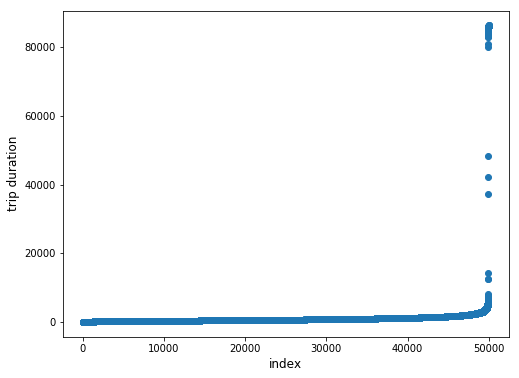

In [4]:
plt.figure(figsize=(8,6))
plt.scatter(range(trainDF.shape[0]), np.sort(trainDF.trip_duration.values))#Y.shape is (n,m). So Y.shape[0] is n.

#Step3.1: Find the outliers & Remove outliers by sorting duration in ascending order:
plt.xlabel('index', fontsize=12)
plt.ylabel('trip duration', fontsize=12)
plt.show()

- Just take the duration data after 99% to avoid the effect of the outliers.  
- Re-plot smoothly.

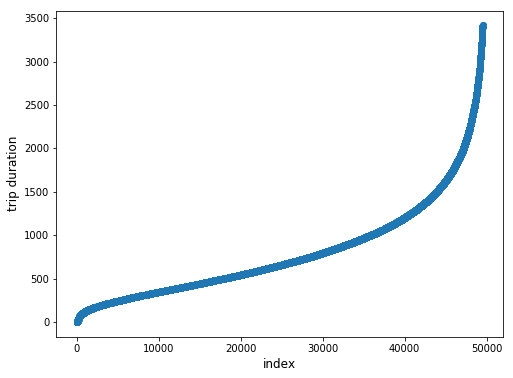

In [5]:
th=trainDF.trip_duration.quantile(0.99)
tempDF=trainDF
tempDF=tempDF[tempDF['trip_duration']<th] #!!!!!!!!!!!!!!! Remain the ones <th

plt.figure(figsize=(8,6))
plt.scatter(range(tempDF.shape[0]),np.sort(tempDF.trip_duration.values))
plt.xlabel('index',fontsize=12)
plt.ylabel('trip duration',fontsize=12)
plt.show()
del tempDF

#### Missing data processing:  
- No missing data after checking.

In [6]:
variable_missing_value=trainDF.isnull().sum()
print('Missing value number of Training DF:\n',variable_missing_value)

variable_missing_value=testDF.isnull().sum()
print('Missing value number of Testing DF:\n',variable_missing_value)

Missing value number of Training DF:
 id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64
Missing value number of Testing DF:
 id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64


#### Data, time and boolen values processing:

In [7]:
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

t0 = dt.datetime.now()
train = trainDF
test = testDF
del trainDF, testDF

#### Add features of date and time for pickup & dropoff.

In [8]:
train['pickup_datetime']=pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)

train.loc[:,'pickup_date']=train['pickup_datetime'].dt.date
test.loc[:,'pickup_date']=test['pickup_datetime'].dt.date

train['dropoff_datetime']=pd.to_datetime(train.dropoff_datetime)

train['store_and_fwd_flag']=1*(train.store_and_fwd_flag.values=='Y')
test['store_and_fwd_flag']=1*(test.store_and_fwd_flag.values=='Y') #!!!!!!!!!!!!!!!!!

print(list(train))

['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration', 'pickup_date']


#### Caculate 'check trip duration(seconds)' based on dropoff and pickup time

In [9]:
train['check_trip_duration'] = (train['dropoff_datetime'] - train['pickup_datetime']).map(lambda x: x.total_seconds()) 
#!!!!!!!!! 1. New column 2. Convert to seconds.

duration_difference=train[np.abs(train['check_trip_duration'].values - train['trip_duration'].values) > 1] #!!!!!!!!!!!Remain the ones with abs>1

print('Trip_Duration & datetime are ok.')
print(list(train))

Trip_Duration & datetime are ok.
['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration', 'pickup_date', 'check_trip_duration']


In [10]:
if len(duration_difference[['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration']])==0:
    print('Items of Duration_difference are 0.')

train['trip_duration'].describe()

count    50000.000000
mean       949.708280
std       3175.391374
min          1.000000
25%        395.000000
50%        659.000000
75%       1071.000000
max      86357.000000
Name: trip_duration, dtype: float64

### Feature extraction by PCA
- Principal components analysis (PCA): 
    - It is used to extract the important information from a multivariate data table and to express this information.   
    - These new variables correspond to a linear combination of the originals. The number of principal components is less than or equal to the number of original variables.

- In this case, I processed the 8 features ('pickup_latitude', 'pickup_longitude', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'dropoff_latitude', 'dropoff_longitude') for corresponding dimension reduction.  
- And generate new feature for storing reducted features.

In [11]:
# np.vstack: Stack arrays in sequence vertically (row wise).
coords=np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                  train[['dropoff_latitude', 'dropoff_longitude']].values,
                  test[['pickup_latitude', 'pickup_longitude']].values,
                  test[['dropoff_latitude', 'dropoff_longitude']].values))

pca=PCA().fit(coords)

#transform(X):Apply dimensionality reduction to X.
train['pickup_pca0']=pca.transform(train[['pickup_latitude','pickup_longitude']])[:,0] 
train['pickup_pca1']=pca.transform(train[['pickup_latitude','pickup_longitude']])[:,1]
train['dropoff_pca0']=pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:,0]
train['dropoff_pca1']=pca.transform(train[['dropoff_latitude','dropoff_longitude']])[:,1]

test['pickup_pca0']=pca.transform(test[['pickup_latitude','pickup_longitude']])[:,0]
test['pickup_pca1']=pca.transform(test[['pickup_latitude','pickup_longitude']])[:,1]
test['dropoff_pca0']=pca.transform(test[['dropoff_latitude','dropoff_longitude']])[:,0]
test['dropoff_pca1']=pca.transform(test[['dropoff_latitude','dropoff_longitude']])[:,1]
#[ : , 0 ] means (more or less) [ first_row:last_row , column_0 ],you get all values in column 0 (from all rows).
#df[['a','b']]: select multiple columns.

## Distance Processing:

- __Defined 3 types of distance for distance caculation :__  
    - Haversine_Array:  
        - The haversine formula determines the <font color='red'>great-circle</font> distance between two points on a sphere given their longitudes and latitudes.
        <img src='Image/462px-Law-of-haversines2.png'>
    - Manhattan Distance:  
        - The distance is based on Haversine array, between two points measured along axes at right angles
    - Bearing Array:  
        - A bearing is used to represent the direction of one point relative to another point.

In [12]:
def haversine_array(lat1,lng1,lat2,lng2):
    lat1,lng1,lat2,lng2=map(np.radians, (lat1,lng1,lat2,lng2))
    AVG_EARTH_RADIUS=6371 # in km 
    lat=lat2-lat1
    lng=lng2-lng1
    d=np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h=2*AVG_EARTH_RADIUS*np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1,lng1,lat2,lng2):
    a=haversine_array(lat1,lng1,lat1,lng2)
    b=haversine_array(lat1,lng1,lat2,lng1)
    return a+b

def bearing_array(lat1,lng1,lat2,lng2):
    AVG_EARTH_RADIUS=6371
    lng_delta_rad=np.radians(lng2-lng1)
    lat1,lng1,lat2,lng2=map(np.radians,(lat1,lng1,lat2,lng2)) #np.radians(): Convert angles from degrees to radians
    y=np.sin(lng_delta_rad)*np.cos(lat2)
    x=np.cos(lat1)*np.sin(lat2)-np.sin(lat1)*np.cos(lat2)*np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y,x))

### Generate features on train and test dataset regarding distance  
__For both train and test dataset__:
- __distance_haversine:__  
    - Generate 'distance of haversine': Based on pickup and dropoff location.  
- __distance_dummy_manhattan:__  
    - Generate 'manhattan distance' based on pickup and dropoff location.  
- __direction:__  
    - Generate bearing direction based on pickup and dropoff location.  
- __pca_manhattan:__  
    - Generate pca for manhanttan based on previous PCA of pickup and dropoff.   
- __center_latitude:__  
    - Get the centroid value of latitude between pickup and dropoff.  
- __center_longitude:__  
    - Get the centroid value of longitude between pickup and dropoff.  

In [13]:
print('train headers:\n',list(train))

train.loc[:,'distance_haversine']=haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:,'distance_dummy_manhattan']=dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:,'direction']=bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:,'pca_manhattan']=np.abs(train['dropoff_pca1']-train['pickup_pca1'])+np.abs(train['dropoff_pca0']-train['pickup_pca0'])
train.loc[:, 'center_latitude'] = (train['pickup_latitude'].values + train['dropoff_latitude'].values) / 2
train.loc[:, 'center_longitude'] = (train['pickup_longitude'].values + train['dropoff_longitude'].values) / 2


test.loc[:,'distance_haversine']=haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:,'distance_dummy_manhattan']=dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:,'direction']=bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:,'pca_manhattan']=np.abs(test['dropoff_pca1']-test['pickup_pca1'])+np.abs(test['dropoff_pca0']-test['pickup_pca0'])
test.loc[:, 'center_latitude'] = (test['pickup_latitude'].values + test['dropoff_latitude'].values) / 2
test.loc[:, 'center_longitude'] = (test['pickup_longitude'].values + test['dropoff_longitude'].values) / 2


train headers:
 ['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration', 'pickup_date', 'check_trip_duration', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1']


### Generate new date/time features for further processing:  
__For both train and test datasets__, this step will transform data/time feature into couple of categerial seperate features for better performance.  

- __pickup_weekday__:  
    - Return the integer day of the week. Categorial transformation.  
- __pickup_hour_weekofyear__:
    - Get the the week ordinal of the year.   
- __pickup_hour__:  
    - Return the hour of the datetime in the underlying data.  
- __pickup_minute__:  
    - Return a numpy array containing the minutes of the datetime in the underlying data  
- __pickup_dt__:  
    - Return seconds for delta between every pickup datetime and minimal(earliest) pickup datetime.  
- __pickup_week_hour__:  
    - Return the current pickup hour of the week.  
- __week_delta__:  
    - Return the float day of week.

In [14]:
#Step8: Datetime features:
train.loc[:,'pickup_hour_weekofyear']=train['pickup_datetime'].dt.weekofyear
train.loc[:,'pickup_weekday']=train['pickup_datetime'].dt.weekday
train.loc[:,'week_delta']=train['pickup_datetime'].dt.weekday+((train['pickup_datetime'].dt.hour+(train['pickup_datetime'].dt.minute/60.0))/24.0)
train.loc[:,'pickup_hour']=train['pickup_datetime'].dt.hour
train.loc[:,'pickup_week_hour']=train['pickup_weekday']*24+train['pickup_hour']
train.loc[:,'pickup_minute']=train['pickup_datetime'].dt.minute
train.loc[:,'pickup_dt']=(train['pickup_datetime']-train['pickup_datetime'].min()).dt.total_seconds()

test.loc[:,'pickup_hour_weekofyear']=test['pickup_datetime'].dt.weekofyear
test.loc[:,'pickup_weekday']=test['pickup_datetime'].dt.weekday
test.loc[:,'week_delta']=test['pickup_datetime'].dt.weekday+((test['pickup_datetime'].dt.hour+(test['pickup_datetime'].dt.minute/60.0))/24.0)
test.loc[:,'pickup_hour']=test['pickup_datetime'].dt.hour
test.loc[:,'pickup_week_hour']=test['pickup_weekday']*24+test['pickup_hour']
test.loc[:,'pickup_minute']=test['pickup_datetime'].dt.minute
test.loc[:,'pickup_dt']=(test['pickup_datetime']-test['pickup_datetime'].min()).dt.total_seconds()

 #### Make time cyclic:  
 - Some data is inherently cyclical. Time is a rich example of this: minutes, hours, seconds, day of week, week of month, month, season, and so on all follow cycles. Ecological features like tide, astrological features like position in orbit, spatial features like rotation or longitude, visual features like color wheels are all naturally cyclical.  
 - Sometimes we want our machine learning model to see that 23:55 and 00:05 are 10 minutes apart, but as it stands, those times may appear to be 23 hours and 50 minutes apart!
- Here’s the trick: we will create two new features, deriving a sine transform and cosine transform of the seconds-past-midnight feature. We can forget the raw “seconds” column from now on.  
<img src='Image/sin-time.png'>
 - __For both train and test dataset, make the hours/weeks/hours to be cyclical__:  
     - __week_delta_sin__:  
         - Turn to accurate float day of week into sin-time.
     - __hour_sin__:  
         - Turn to pickup_hour into sin-time.

In [15]:
train.loc[:,'week_delta_sin']=np.sin((train['week_delta']/7)*np.pi)**2
train.loc[:,'hour_sin']=np.sin((train['pickup_hour']/24)*np.pi)**2

test.loc[:,'week_delta_sin']=np.sin((test['week_delta']/7)*np.pi)**2
test.loc[:,'hour_sin']=np.sin((test['pickup_hour']/24)*np.pi)**2

### Trip Speed Processing:  
- For Train dataset, created new features for the average speed based on different distance:  
    - avg_speed_h:  
        - Caculate the average speed based on Haversine distance.  
    - avg_speed_m:  
        - Caculate the average speed based on Manhattan distance. 

In [16]:
train.loc[:,'avg_speed_h']=1000*train['distance_haversine']/train['trip_duration']
train.loc[:,'avg_speed_m']=1000*train['distance_dummy_manhattan']/train['trip_duration']

train.loc[:,'pickup_lat_bin']=np.round(train['pickup_latitude'],3)
train.loc[:,'pickup_long_bin']=np.round(train['pickup_longitude'],3)

In [17]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'check_trip_duration', 'pickup_pca0',
       'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'distance_haversine',
       'distance_dummy_manhattan', 'direction', 'pca_manhattan',
       'center_latitude', 'center_longitude', 'pickup_hour_weekofyear',
       'pickup_weekday', 'week_delta', 'pickup_hour', 'pickup_week_hour',
       'pickup_minute', 'pickup_dt', 'week_delta_sin', 'hour_sin',
       'avg_speed_h', 'avg_speed_m', 'pickup_lat_bin', 'pickup_long_bin'],
      dtype='object')

####  Get the average speed by regions(lat, long):  
   - Processed the lat/long/centroid by round.  
   - Group by average speed based on Haversine distance.  
   - Count the numbers of each average speed.  
   - Remain the observations with id>100.

In [18]:
#Step9.1: Average speed for regions:
gby_cols=['pickup_lat_bin','pickup_long_bin']

coord_speed=train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count=train.groupby(gby_cols).count()[['id']].reset_index() #!!!!!!!reset_index()
coord_stats=pd.merge(coord_speed, coord_count,on=gby_cols)
coord_stats=coord_stats[coord_stats['id']>100]

train.loc[:,'pickup_lat_bin']=np.round(train['pickup_latitude'],2)
train.loc[:,'pickup_long_bin']=np.round(train['pickup_longitude'],2)
train.loc[:,'center_lat_bin']=np.round(train['center_latitude'],2)
train.loc[:,'center_long_bin']=np.round(train['center_longitude'],2)
train.loc[:,'pickup_dt_bin']=(train['pickup_dt']//(3*3600)) #Floor division - division that results into whole number adjusted to the left in the number line

test.loc[:,'pickup_lat_bin']=np.round(test['pickup_latitude'],2)
test.loc[:,'pickup_long_bin']=np.round(test['pickup_longitude'],2)
test.loc[:,'center_lat_bin']=np.round(test['center_latitude'],2)
test.loc[:,'center_long_bin']=np.round(test['center_longitude'],2)
test.loc[:,'pickup_dt_bin']=(test['pickup_dt']//(3*3600)) #Floor division - division that results into whole number adjusted to the left in the number line


## Clustering & Predict by MiniBatchKMeans  
- We have 1350268 coords records with features of 'pickup_latitude', 'pickup_longitude', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'dropoff_latitude', 'dropoff_longitude'.   
- For these coords records, I conducted MiniBatchKMeans:  
    - __MiniBatchKMeans__: 
       - MiniBatchKMeans is a variant of the KMeans algorithm which uses mini-batches to reduce the computation time, while still attempting to optimise the same objective function. 
       - The MiniBatchKMeans is faster and reduce the computation expense greatly.  
       - __Step 1__: samples are drawn randomly from the dataset, to form a mini-batch. These are then assigned to the nearest centroid.   
       - __Step 2__: the centroids are updated.(In contrast to k-means, this is done on a per-sample basis.)These steps are performed until convergence or a predetermined number of iterations is reached.
       - __Parameters__:
           - __n_clusters:__ The number of clusters to form as well as the number of centroids to generate.  
           - __batch_size:__ Size of the mini batches. The larger the the size of the batch, the more computationally costly the training process.

In [19]:
#Shuffle the coords and get 500000 items from it.
sample_ind=np.random.permutation(len(coords))[:500000] #np.random.permutation: Randomly permute a sequence, or return a permuted range.
print('the length of coords:\n', len(coords))

kmeans=MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])
#MiniBatchKMeans: batch_size controls the number of randomly selected observations in each batch. 

the length of coords:
 1350268


#### Cluster by MiniBatchKMeans:  
- New features created for storing the predictions based on the lat/long of pickup/dropoff.

In [20]:
train.loc[:,'pickup_cluster']=kmeans.predict(train[['pickup_latitude','pickup_longitude']])
train.loc[:,'dropoff_cluster']=kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:,'pickup_cluster']=kmeans.predict(test[['pickup_latitude','pickup_longitude']])
test.loc[:,'dropoff_cluster']=kmeans.predict(test[['dropoff_latitude','dropoff_longitude']])

t1=dt.datetime.now()
print('Time for clustering: %i seconds' %(t1-t0).seconds) #!!!!!!!!!!!!!!!!!!!!

Time for clustering: 112 seconds


- We'll need to log transform this 'trip_duration' variable so that it becomes normally distributed.

In [21]:
train['log_trip_duration']=np.log(train['trip_duration'].values+1)

In [22]:
train.head(3)

id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:00 2016-03-14 17:32:00   
1  id2377394          1 2016-06-12 00:43:00 2016-06-12 00:54:00   
2  id3858529          2 2016-01-19 11:35:00 2016-01-19 12:10:00   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   

   dropoff_latitude  store_and_fwd_flag  ...  avg_speed_h avg_speed_m  \
0         40.765602                   0  ...     3.293453    3.814141   
1         40.731152                   0  ...     2.723239    3.665923   
2         40.710087                   0  ...     3.006167    3.862324   

   pickup_lat_bin  pickup_long_bin  center_lat_bin  center_long_bin  \
0           40.77           -73.98           40.77           -73.97   
1           40.74           -73.98           40.73           -73.99   
2           40.76           -73.98           40.74           -73.99   

   pickup_dt_bin  pickup_cluster  dropoff_cluster  log_trip_duration  
0          589.0              91               95           6.122493  
1         1304.0              80               65           6.498282  
2          147.0               5               98           7.661527  

[3 rows x 42 columns]

## Temporal and geospatial aggregation   
__For both train and test datasets__:
   - At first, created new features by grouping by combination of  Average speeds based on Haversine, Manhattan and logged trip duration.
   - Merge the new grouped dataset  

Next, __For both train and test datasets__:  
   - Grouped columns combinations based on different features, like average speed of Haversine, and count by id.  
   - Created new dataset by merging with grouped dataset of average speed of Haversine and dataset of count by id.

In [23]:
for gby_col in ['pickup_hour','pickup_date','pickup_dt_bin','pickup_week_hour','pickup_cluster','dropoff_cluster']:
    gby = train.groupby(gby_col).mean()[['avg_speed_h','avg_speed_m','log_trip_duration']]
    gby.columns = ['%s_gby_%s' % (col, gby_col) for col in gby.columns]
    
    train = pd.merge(train, gby, how='left',left_on=gby_col,right_index=True)
    test = pd.merge(test, gby, how='left', left_on=gby_col, right_index=True)
    
    #how: left: use only keys from left frame, similar to a SQL left outer join; preserve key order
    #right_index: Use the index from the right DataFrame as the join key.
    #left_on, right_on for assigning the columns names, in order to align with the corresponding col names for further merging.


for gby_cols in [['center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'pickup_cluster'],  ['pickup_hour', 'dropoff_cluster'],
                 ['pickup_cluster', 'dropoff_cluster']]:
    coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
    coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
    
    coord_stats = pd.merge(coord_speed, coord_count, on = gby_cols)
    coord_stats.columns = gby_cols + ['avg_speed_h_%s' % '_'.join(gby_cols),'cnt_%s' % '_'.join(gby_cols)]
    
    #.columns attribute returns an index containg the column names of df.
    # df. columns: Get all labels of all columns，df.index: get all labels of all rows.
    #eg.:df.columns: Get: Index(['ColumnOne', 'ColumnTwo'], dtype=
    
    train=pd.merge(train,coord_stats,how='left',on=gby_cols)
    test=pd.merge(test,coord_stats,how='left',on=gby_cols)
 

In [24]:
train.head(3)

id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:00 2016-03-14 17:32:00   
1  id2377394          1 2016-06-12 00:43:00 2016-06-12 00:54:00   
2  id3858529          2 2016-01-19 11:35:00 2016-01-19 12:10:00   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   

   dropoff_latitude  store_and_fwd_flag  ...  \
0         40.765602                   0  ...   
1         40.731152                   0  ...   
2         40.710087                   0  ...   

   avg_speed_h_center_lat_bin_center_long_bin  \
0                                    3.581992   
1                                    3.534788   
2                                    3.402122   

  cnt_center_lat_bin_center_long_bin  \
0                               2020   
1                               1803   
2                               2823   

   avg_speed_h_pickup_hour_center_lat_bin_center_long_bin  \
0                                           3.045406        
1                                           3.419741        
2                                           3.025884        

   cnt_pickup_hour_center_lat_bin_center_long_bin  \
0                                             146   
1                                              90   
2                                             126   

   avg_speed_h_pickup_hour_pickup_cluster  cnt_pickup_hour_pickup_cluster  \
0                                3.099245                              90   
1                                4.492336                              21   
2                                2.839144                              46   

   avg_speed_h_pickup_hour_dropoff_cluster  cnt_pickup_hour_dropoff_cluster  \
0                                 3.096658                               48   
1                                 3.513094                               36   
2                                 4.196762                               24   

   avg_speed_h_pickup_cluster_dropoff_cluster  \
0                                    3.105947   
1                                    2.543626   
2                                    5.005307   

   cnt_pickup_cluster_dropoff_cluster  
0                                  19  
1                                  11  
2                                   5  

[3 rows x 70 columns]

## Get trips around 60 min  
- __For both train and test datasets__: Created a new feature of 'pickup_datetime_group'  
    - by performing round operation on the pickup datetime grouped to the specified freq.

In [25]:
group_freq = '60min'
df_all = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]

train.loc[:, 'pickup_datetime_group'] = train['pickup_datetime'].dt.round(group_freq)
test.loc[:, 'pickup_datetime_group'] = test['pickup_datetime'].dt.round(group_freq)

c:\python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [26]:
train.head(3)

id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:00 2016-03-14 17:32:00   
1  id2377394          1 2016-06-12 00:43:00 2016-06-12 00:54:00   
2  id3858529          2 2016-01-19 11:35:00 2016-01-19 12:10:00   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   

   dropoff_latitude  store_and_fwd_flag  ...  \
0         40.765602                   0  ...   
1         40.731152                   0  ...   
2         40.710087                   0  ...   

   cnt_center_lat_bin_center_long_bin  \
0                                2020   
1                                1803   
2                                2823   

  avg_speed_h_pickup_hour_center_lat_bin_center_long_bin  \
0                                           3.045406       
1                                           3.419741       
2                                           3.025884       

   cnt_pickup_hour_center_lat_bin_center_long_bin  \
0                                             146   
1                                              90   
2                                             126   

   avg_speed_h_pickup_hour_pickup_cluster  cnt_pickup_hour_pickup_cluster  \
0                                3.099245                              90   
1                                4.492336                              21   
2                                2.839144                              46   

   avg_speed_h_pickup_hour_dropoff_cluster  cnt_pickup_hour_dropoff_cluster  \
0                                 3.096658                               48   
1                                 3.513094                               36   
2                                 4.196762                               24   

   avg_speed_h_pickup_cluster_dropoff_cluster  \
0                                    3.105947   
1                                    2.543626   
2                                    5.005307   

   cnt_pickup_cluster_dropoff_cluster  pickup_datetime_group  
0                                  19    2016-03-14 17:00:00  
1                                  11    2016-06-12 01:00:00  
2                                   5    2016-01-19 12:00:00  

[3 rows x 71 columns]

#### Count trips over 60min:  
   - By generating new feature of 'count_60min' to store the trips beyond 60 mins.
   - For both train and test datasets:
        - Merged this counts together to check how many trips> 60 mins in each group correspondingly. 

In [27]:
df_counts = df_all.set_index('pickup_datetime')[['id']].sort_index()
df_counts['count_60min'] = df_counts.isnull().rolling(group_freq).count()['id'] 
# group_freq = '60min': it only starts having valid values when there are three periods over which to look back.
#https://towardsdatascience.com/basic-time-series-manipulation-with-pandas-4432afee64ea
# time-indexed DataFrame will roll a variable length window corresponding to the time period.

train = train.merge(df_counts, on='id', how='left')
test = test.merge(df_counts, on='id', how='left')

train.head(3)

id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:00 2016-03-14 17:32:00   
1  id2377394          1 2016-06-12 00:43:00 2016-06-12 00:54:00   
2  id3858529          2 2016-01-19 11:35:00 2016-01-19 12:10:00   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   

   dropoff_latitude  store_and_fwd_flag  ...  \
0         40.765602                   0  ...   
1         40.731152                   0  ...   
2         40.710087                   0  ...   

   avg_speed_h_pickup_hour_center_lat_bin_center_long_bin  \
0                                           3.045406        
1                                           3.419741        
2                                           3.025884        

  cnt_pickup_hour_center_lat_bin_center_long_bin  \
0                                            146   
1                                             90   
2                                            126   

   avg_speed_h_pickup_hour_pickup_cluster  cnt_pickup_hour_pickup_cluster  \
0                                3.099245                              90   
1                                4.492336                              21   
2                                2.839144                              46   

   avg_speed_h_pickup_hour_dropoff_cluster  cnt_pickup_hour_dropoff_cluster  \
0                                 3.096658                               48   
1                                 3.513094                               36   
2                                 4.196762                               24   

   avg_speed_h_pickup_cluster_dropoff_cluster  \
0                                    3.105947   
1                                    2.543626   
2                                    5.005307   

   cnt_pickup_cluster_dropoff_cluster  pickup_datetime_group  count_60min  
0                                  19    2016-03-14 17:00:00        206.0  
1                                  11    2016-06-12 01:00:00        201.0  
2                                   5    2016-01-19 12:00:00        181.0  

[3 rows x 72 columns]

- Count the dropoff by grouping 'dropoff_cluster' with rolling of '240mins'.

In [28]:
dropoff_counts = df_all \
    .set_index('pickup_datetime') \
    .groupby([pd.TimeGrouper(group_freq), 'dropoff_cluster']) \
    .agg({'id': 'count'}) \
    .reset_index().set_index('pickup_datetime') \
    .groupby('dropoff_cluster').rolling('240min').mean() \
    .drop('dropoff_cluster', axis=1) \
    .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
    .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'dropoff_cluster_count'})

c:\python37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  This is separate from the ipykernel package so we can avoid doing imports until


- Merge the dropoff_counts datasets with train, test datasets of 2 features 'pickup_datetime_group' and 'dropoff_cluster'.
- In order to explore how many dropoff by the pickup datetime and predicted cluster of dropoff lat/long.

In [29]:
train['dropoff_cluster_count'] = train[['pickup_datetime_group', 'dropoff_cluster']].merge(dropoff_counts, on=['pickup_datetime_group', 'dropoff_cluster'], how='left')['dropoff_cluster_count'].fillna(0)
test['dropoff_cluster_count'] = test[['pickup_datetime_group', 'dropoff_cluster']].merge(dropoff_counts, on=['pickup_datetime_group', 'dropoff_cluster'], how='left')['dropoff_cluster_count'].fillna(0)

#### Count the pickup by grouping 'pickup_cluster' with rolling of '240mins'. (Count how many trips are going from each cluster over time)

In [30]:
df_all = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]

pickup_counts = df_all \
    .set_index('pickup_datetime') \
    .groupby([pd.TimeGrouper(group_freq), 'pickup_cluster']) \
    .agg({'id': 'count'}) \
    .reset_index().set_index('pickup_datetime') \
    .groupby('pickup_cluster').rolling('240min').mean() \
    .drop('pickup_cluster', axis=1) \
    .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
    .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'pickup_cluster_count'})

c:\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.
c:\python37\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  """


- Merge the pickup_cluster_count datasets with train, test datasets of 2 features 'pickup_datetime_group' and 'pickup_cluster'.
- In order to explore how many pickup trips given the pickup datetime and predicted cluster of pickup lat/long.

In [31]:
train['pickup_cluster_count'] = train[['pickup_datetime_group', 'pickup_cluster']].merge(pickup_counts, on=['pickup_datetime_group', 'pickup_cluster'], how='left')['pickup_cluster_count'].fillna(0)
test['pickup_cluster_count'] = test[['pickup_datetime_group', 'pickup_cluster']].merge(pickup_counts, on=['pickup_datetime_group', 'pickup_cluster'], how='left')['pickup_cluster_count'].fillna(0)

##  OSRM data for further processing.

- For this particular problem we can add OSRM ([Open Source Routing Machine](http://project-osrm.org/ "OSRM")) features:  
    - id  
    - starting_street, end_street  
    - total_distance, total_travel_time  
    - number_of_steps  
    - street_for_each_step, distance_per_step  
    - travel_time_per_step  
    - step_maneuvers, step_direction, step_location_list  
- This data contains the fastest routes from specific starting points in NY.  
- In this case, we used 'id', 'total_travel_time',  'number_of_steps' of OSRM data and merged them for training & testing datasets.

In [32]:
fr1 = pd.read_csv('data/osrm/fastest_routes_train_part_1.csv',
                  usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps'])

fr2 = pd.read_csv('data/osrm/fastest_routes_train_part_2.csv',
                  usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])

test_street_info = pd.read_csv('data/osrm/fastest_routes_test.csv',
                               usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])

In [33]:
train_street_info=pd.concat((fr1, fr2))
train = train.merge(train_street_info, how='left', on='id')
test = test.merge(test_street_info, how='left', on='id')
train.head(3)

id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:00 2016-03-14 17:32:00   
1  id2377394          1 2016-06-12 00:43:00 2016-06-12 00:54:00   
2  id3858529          2 2016-01-19 11:35:00 2016-01-19 12:10:00   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   

   dropoff_latitude  store_and_fwd_flag  ...  cnt_pickup_hour_dropoff_cluster  \
0         40.765602                   0  ...                               48   
1         40.731152                   0  ...                               36   
2         40.710087                   0  ...                               24   

  avg_speed_h_pickup_cluster_dropoff_cluster  \
0                                   3.105947   
1                                   2.543626   
2                                   5.005307   

   cnt_pickup_cluster_dropoff_cluster  pickup_datetime_group  count_60min  \
0                                  19    2016-03-14 17:00:00        206.0   
1                                  11    2016-06-12 01:00:00        201.0   
2                                   5    2016-01-19 12:00:00        181.0   

   dropoff_cluster_count  pickup_cluster_count  total_distance  \
0                    4.5              8.750000          2009.1   
1                    3.5              2.666667          2513.2   
2                    2.0              4.250000         11060.8   

   total_travel_time  number_of_steps  
0              164.9                5  
1              332.0                6  
2              767.6               16  

[3 rows x 77 columns]

## Feature extraction...  
- Filter 5 unuseful features out.

In [34]:
#Filter the features we used.
feature_names = list(train.columns)
print(np.setdiff1d(train.columns, test.columns)) #setdiff1d():Return the sorted, unique values in ar1 that are not in ar2.
do_not_use_for_training = ['id', 'log_trip_duration', 'pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration',
                           'pickup_date', 'avg_speed_h', 'avg_speed_m', 'pickup_lat_bin', 'pickup_long_bin',
                           'center_lat_bin', 'center_long_bin', 'pickup_dt_bin', 'pickup_datetime_group']

feature_names = [f for f in train.columns if f not in do_not_use_for_training]

print('We have %i features.' % len(feature_names))
train[feature_names].count()

t1 = dt.datetime.now()
print('Feature extraction time: %i seconds' % (t1 - t0).seconds)

['avg_speed_h' 'avg_speed_m' 'check_trip_duration' 'dropoff_datetime'
 'log_trip_duration' 'trip_duration']
We have 62 features.
Feature extraction time: 167 seconds


#### Desribe some features  before modeling  
- Add some descriptive features based on filtered features on training and test datasets.  
    - nanmean: Compute the arithmetic mean along the specified axis.  
    - nanstd: Compute the standard deviation along the specified axis.  
    - Get Mean Difference and absolute difference of train & test dataset based on mean & standard deviation:  
        - Mean Difference measures the absolute difference between the mean value in two different groups.

In [35]:
feature_stats = pd.DataFrame({'feature': feature_names})

# axis=0:the first running vertically downwards across rows (axis 0), 
# and the second running horizontally across columns (axis 1)
#np.nanmean(): Compute the arithmetic mean along the specified axis, ignoring NaNs.

feature_stats.loc[:, 'train_mean'] = np.nanmean(train[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'test_mean'] = np.nanmean(test[feature_names].values, axis=0).round(4)

feature_stats.loc[:, 'train_std'] = np.nanstd(train[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'test_std'] = np.nanstd(test[feature_names].values, axis=0).round(4)

feature_stats.loc[:, 'train_nan'] = np.mean(np.isnan(train[feature_names].values), axis=0).round(3)
feature_stats.loc[:, 'test_nan'] = np.mean(np.isnan(test[feature_names].values), axis=0).round(3)

feature_stats.loc[:, 'train_test_mean_diff'] = np.abs(feature_stats['train_mean'] - feature_stats['test_mean']) / np.abs(feature_stats['train_std'] + feature_stats['test_std'])  * 2
feature_stats.loc[:, 'train_test_nan_diff'] = np.abs(feature_stats['train_nan'] - feature_stats['test_nan'])

feature_stats = feature_stats.sort_values(by='train_test_mean_diff')
feature_stats[['feature', 'train_test_mean_diff']].tail()


feature  train_test_mean_diff
55                 cnt_pickup_cluster_dropoff_cluster              0.029200
51                     cnt_pickup_hour_pickup_cluster              0.031023
54         avg_speed_h_pickup_cluster_dropoff_cluster              0.031720
53                    cnt_pickup_hour_dropoff_cluster              0.044322
48  avg_speed_h_pickup_hour_center_lat_bin_center_...              0.045448

## Train classifier for prediction trip duration:

### Handle the cross validation and hyperparameters by TPOT

__TPOT(Tree-Based Pipeline Optimization Tool)__:
   - TPOT was one of the very first AutoML methods and open-source software packages.  
   - The goal of TPOT is to automate the building of ML pipelines by combining a flexible expression tree representation of pipelines with stochastic search algorithms  
   - It works by intelligently exploring thousands of possible pipelines to find the best one for data.
   <img src='Image/tpot-pipeline-example.png'>
   -An example Machine Learning pipeline
   <img src='Image/tpot-ml-pipeline.png'>  

- __Parameters__:  
     - __generations:__ 
         - Number of iterations to the run pipeline optimization process. Must be a positive number. Generally, TPOT will work better when you give it more generations (and therefore time) to optimize the pipeline.
     - __population_size:__     
         - Number of individuals to retain in the genetic programming population every generation. Must be a positive number. Generally, TPOT will work better when you give it more individuals with which to optimize the pipeline.  
     - __verbosity__:  
         - How much information TPOT communicates while it is running. 0 = none, 1 = minimal, 2 = high, 3 = all. A setting of 2 or higher will add a progress bar during the optimization procedure.

In [37]:
from tpot import TPOTRegressor
auto_classifier = TPOTRegressor(generations=3, population_size=9, verbosity=2)
from sklearn.model_selection import train_test_split

#### Split the training data to train and validate by K Fold Cross Validation

__Cross-validation:__    
- It is a resampling procedure used to evaluate machine learning models on a limited data sample.  
- K refers to the number of groups that a given data sample is to be split into.   
- It uses a limited sample in order to estimate how the model is expected to perform in general when used to make predictions on data not used during the training of the model.  
- __How__:  
    - Step 1: Shuffle the dataset randomly.
    - Step 2: Split the dataset into k groups
    - Step 3: For each unique group:
        - 3.1 Take the group: as a hold out or test data set
        - 3.2 Take the remaining groups: as a training data set
        - 3.3 Fit a model on the training set and evaluate it on the test set
        - 3.4: Retain the evaluation score and discard the model
    - Step 5: Summarize the skill of the model using the sample of model evaluation scores
    - Flowchart of typical cross validation workflow:  
    <img src='Image/grid_search_workflow2.png'>

#### Get the datasets after k-folds

In [38]:
from sklearn.model_selection import KFold

In [39]:
X = train[feature_names].values
y = np.log(train['trip_duration'].values + 1) #SetTarget feature: trip_Duration.

kf = KFold(n_splits=10)
kf.get_n_splits(X)

print("feature names:\n", feature_names)
print("x:\n",X)
print("y:\n",y)  

KFold(n_splits=10, random_state=None, shuffle=False)

for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]

feature names:
 ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'distance_haversine', 'distance_dummy_manhattan', 'direction', 'pca_manhattan', 'center_latitude', 'center_longitude', 'pickup_hour_weekofyear', 'pickup_weekday', 'week_delta', 'pickup_hour', 'pickup_week_hour', 'pickup_minute', 'pickup_dt', 'week_delta_sin', 'hour_sin', 'pickup_cluster', 'dropoff_cluster', 'avg_speed_h_gby_pickup_hour', 'avg_speed_m_gby_pickup_hour', 'log_trip_duration_gby_pickup_hour', 'avg_speed_h_gby_pickup_date', 'avg_speed_m_gby_pickup_date', 'log_trip_duration_gby_pickup_date', 'avg_speed_h_gby_pickup_dt_bin', 'avg_speed_m_gby_pickup_dt_bin', 'log_trip_duration_gby_pickup_dt_bin', 'avg_speed_h_gby_pickup_week_hour', 'avg_speed_m_gby_pickup_week_hour', 'log_trip_duration_gby_pickup_week_hour', 'avg_speed_h_gby_pickup_cluster', 'avg_speed_m_gby_pickup_clu

#### Train TPOT by k-folds  
- In this case, we have splits=10 for folds.  
- TPOT will fit the X_train and target for generating the optimum model with hyperparameters by CV score.

In [40]:
auto_classifier.fit(X_train, y_train)

Generation 1 - Current best internal CV score: -0.1470238507301496
Generation 2 - Current best internal CV score: -0.1470238507301496
Generation 3 - Current best internal CV score: -0.1470238507301496

Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=100, nthread=1, objective=reg:squarederror, subsample=0.7000000000000001)


TPOTRegressor(config_dict=None, crossover_rate=0.1, cv=5,
       disable_update_check=False, early_stop=None, generations=3,
       max_eval_time_mins=5, max_time_mins=None, memory=None,
       mutation_rate=0.9, n_jobs=1, offspring_size=None,
       periodic_checkpoint_folder=None, population_size=9,
       random_state=None, scoring=None, subsample=1.0, template=None,
       use_dask=False, verbosity=2, warm_start=False)

- The cv score could be increased by tuning the TPOT parameters:  
    - generations: Generally, TPOT will work better when you give it more generations (and therefore time) to optimize the pipeline.  
    - population_size:  Generally, TPOT will work better when you give it more individuals with which to optimize the pipeline.

####  Save the test[feature_names] to csv file.

In [41]:
print(feature_names)
print(test[feature_names].head(5))
test[feature_names].to_csv('NYCTaxi_DataTest.csv', index=False)

['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'distance_haversine', 'distance_dummy_manhattan', 'direction', 'pca_manhattan', 'center_latitude', 'center_longitude', 'pickup_hour_weekofyear', 'pickup_weekday', 'week_delta', 'pickup_hour', 'pickup_week_hour', 'pickup_minute', 'pickup_dt', 'week_delta_sin', 'hour_sin', 'pickup_cluster', 'dropoff_cluster', 'avg_speed_h_gby_pickup_hour', 'avg_speed_m_gby_pickup_hour', 'log_trip_duration_gby_pickup_hour', 'avg_speed_h_gby_pickup_date', 'avg_speed_m_gby_pickup_date', 'log_trip_duration_gby_pickup_date', 'avg_speed_h_gby_pickup_dt_bin', 'avg_speed_m_gby_pickup_dt_bin', 'log_trip_duration_gby_pickup_dt_bin', 'avg_speed_h_gby_pickup_week_hour', 'avg_speed_m_gby_pickup_week_hour', 'log_trip_duration_gby_pickup_week_hour', 'avg_speed_h_gby_pickup_cluster', 'avg_speed_m_gby_pickup_cluster', 'log_trip

#### Predict and export trip duration with the trained TPOT classifier

In [42]:
test_result = auto_classifier.predict(test[feature_names].values)

sub = pd.DataFrame()
sub['id'] = test['id']
sub['trip_duration'] = np.exp(test_result) 
#np.exp: Calculate the exponential of all elements in the input array.
sub['pickup_weekday']=test['pickup_weekday']
sub.to_csv('NYCTaxi_TpotModels.csv', index=False)
sub.head()
      
auto_classifier.export('NYCTaxi_TPOTpipelineResult.py')

Imputing missing values in feature set


#### Check if any null data in the result.

In [43]:
trainDF = pd.read_csv('NYCTaxi_DataTest.csv', nrows=10000)
print(trainDF.isnull().any())

vendor_id                                                 False
passenger_count                                           False
pickup_longitude                                          False
pickup_latitude                                           False
dropoff_longitude                                         False
dropoff_latitude                                          False
store_and_fwd_flag                                        False
pickup_pca0                                               False
pickup_pca1                                               False
dropoff_pca0                                              False
dropoff_pca1                                              False
distance_haversine                                        False
distance_dummy_manhattan                                  False
direction                                                 False
pca_manhattan                                             False
center_latitude                         

#### Process the null data in some features  
- Filled the null data with mean()

In [44]:
#Fill nan of columns:
trainDF['avg_speed_h_center_lat_bin_center_long_bin'].fillna((trainDF['avg_speed_h_center_lat_bin_center_long_bin'].mean()), inplace=True)
trainDF['cnt_center_lat_bin_center_long_bin'].fillna((trainDF['cnt_center_lat_bin_center_long_bin'].mean()), inplace=True)
trainDF['avg_speed_h_pickup_hour_center_lat_bin_center_long_bin'].fillna((trainDF['avg_speed_h_pickup_hour_center_lat_bin_center_long_bin'].mean()), inplace=True)
trainDF['cnt_pickup_hour_center_lat_bin_center_long_bin'].fillna((trainDF['cnt_pickup_hour_center_lat_bin_center_long_bin'].mean()), inplace=True)
trainDF['avg_speed_h_pickup_hour_pickup_cluster'].fillna((trainDF['avg_speed_h_pickup_hour_pickup_cluster'].mean()), inplace=True)
trainDF['cnt_pickup_hour_pickup_cluster'].fillna((trainDF['cnt_pickup_hour_pickup_cluster'].mean()), inplace=True)
trainDF['avg_speed_h_pickup_hour_dropoff_cluster'].fillna((trainDF['avg_speed_h_pickup_hour_dropoff_cluster'].mean()), inplace=True)
trainDF['cnt_pickup_hour_dropoff_cluster'].fillna((trainDF['cnt_pickup_hour_dropoff_cluster'].mean()), inplace=True)
trainDF['avg_speed_h_pickup_cluster_dropoff_cluster'].fillna((trainDF['avg_speed_h_pickup_cluster_dropoff_cluster'].mean()), inplace=True)
trainDF['cnt_pickup_cluster_dropoff_cluster'].fillna((trainDF['cnt_pickup_cluster_dropoff_cluster'].mean()), inplace=True)


#  Animate the map with time changing

In [46]:
#import pandas as pd  #pandas for using dataframe and reading csv 
import numpy as np   #numpy for vector operations and basic maths 
#import simplejson    #getting JSON in simplified format
import urllib        #for url stuff
#import gmaps       #for using google maps to visulalize places on maps
import re            #for processing regular expressions
import datetime      #for datetime operations
import calendar      #for calendar for datetime operations
import time          #to get the system time
import scipy         #for other dependancies
from sklearn.cluster import KMeans # for doing K-means clustering
from haversine import haversine # for calculating haversine distance
import math          #for basic maths operations
import seaborn as sns #for making plots
import matplotlib.pyplot as plt # for plotting
import os  # for os commands
# from scipy.misc import imread, imresize, imsave  # for plots 
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show
from IPython.display import HTML
from matplotlib.pyplot import *
from matplotlib import cm
from matplotlib import animation
import io
import base64
output_notebook()
plotly.offline.init_notebook_mode() # run at the start of every ipython notebook

Loading BokehJS ...

### Load data & Processing  
- Create new dataset based on ORSM dataset with columns of 'id', 'total_distance', 'total_travel_time', 'number_of_steps'.  
- Merge this new dataset with train dataset.

In [48]:
s = time.time()
train_fr_1 = pd.read_csv('data/osrm/fastest_routes_train_part_1.csv')
train_fr_2 = pd.read_csv('data/osrm/fastest_routes_train_part_2.csv')
train_fr = pd.concat([train_fr_1, train_fr_2])
train_fr_new = train_fr[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]

train_df = pd.read_csv('data/train.csv')
train = pd.merge(train_df, train_fr_new, on = 'id', how = 'left')
train_df = train.copy()
end = time.time()
print("Time taken: {}.".format((end-s)))

Time taken: 27.85045051574707.


#### Check the dataset and filter by rules:  
- Get the shape and number of null data of new train dataset.  
- Filter the data by following rule: We just remain the observations within the range of :  
        - latitude: 40.6-40.9  
        - longitude: -74.05--73.7

In [49]:
# checking if Ids are unique, and the number of Nulls.
start = time.time()
train_data = train_df.copy()
start = time.time()
print("Respectively, number of columns and rows and columns are {} and {} .".format(train_data.shape[1], train_data.shape[0]))
if train_data.id.nunique() == train_data.shape[0]: #nunique(): Return number of unique elements in the object.
    print("Train ids are unique")
print("Number of Nulls : {}.".format(train_data.isnull().sum().sum()))

# Remain the items with latitude & longitude between 40.6-40.9 and -74.05--73.7:
%matplotlib inline

df = train_df.loc[(train_df.pickup_latitude > 40.6) & (train_df.pickup_latitude < 40.9)]
df = df.loc[(df.dropoff_latitude>40.6) & (df.dropoff_latitude < 40.9)]
df = df.loc[(df.dropoff_longitude > -74.05) & (df.dropoff_longitude < -73.7)]
df = df.loc[(df.pickup_longitude > -74.05) & (df.pickup_longitude < -73.7)]

train_data_new = df.copy()
print(train_data_new.head(4))
end = time.time()
print("Time taken {}.".format(end-start))

Respectively, number of columns and rows and columns are 14 and 1048575 .
Train ids are unique
Number of Nulls : 0.
          id  vendor_id  pickup_datetime dropoff_datetime  passenger_count  \
0  id2875421          2  3/14/2016 17:24  3/14/2016 17:32                1   
1  id2377394          1   6/12/2016 0:43   6/12/2016 0:54                1   
2  id3858529          2  1/19/2016 11:35  1/19/2016 12:10                1   
3  id3504673          2   4/6/2016 19:32   4/6/2016 19:39                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.982155        40.767937         -73.964630         40.765602   
1        -73.980415        40.738564         -73.999481         40.731152   
2        -73.979027        40.763939         -74.005333         40.710087   
3        -74.010040        40.719971         -74.012268         40.706718   

  store_and_fwd_flag  trip_duration  total_distance  total_travel_time  \
0                  N            4

#### Checking other factors might affect the trip duration
- Like the correlation with vendors/drivers by 'vendor_id':
    - The corrlation will be plotted with vendor_id(1,2) and their trip duration.

In [50]:
temp = train_data.copy()

train_data['pickup_datetime'] = pd.to_datetime(train_data.pickup_datetime)
train_data.loc[:, 'pick_date'] = train_data['pickup_datetime'].dt.date
train_data.head()

ts_v1 = pd.DataFrame(train_data.loc[train_data['vendor_id']==1].groupby('pick_date')['trip_duration'].mean())
ts_v1.reset_index(inplace = True)
ts_v2 = pd.DataFrame(train_data.loc[train_data.vendor_id==2].groupby('pick_date')['trip_duration'].mean())
ts_v2.reset_index(inplace = True)

train_data = temp

#Basic image processing

#### Then take a summary of lat-long and their count, assign a different color for different count range.

 - Consider each point of this image as a point represented by lat-long

#### Initialize and handle the pick&drop lat-long for further plot.  
- Create 3D arrays rgb[row, cols, depth]: 3000 rows with 3500 columns & 3 columns each.
- Create new columns for pick/drop and lat/long for storing the location difference.
- Group the dataset by counting the pickup and dropoff id with similar location, so that we could know the potential density of the region.

In [51]:
# rbg[lat, long, 0/1/2]: 

rgb = np.zeros((3000, 3500, 3), dtype=np.uint8) # 3000 arrays: with 3500 rows & 3 columns each.
rgb[..., 0] = 0 # Assign 0 to every items in column 0;
rgb[..., 1] = 0 # Assign 0 to every items in column 1;
rgb[..., 2] = 0 # Assign 0 to every items in column 2;

train_data_new['pick_lat_new'] = list(map(int, (train_data_new['pickup_latitude'] - (40.6000))*10000))
train_data_new['drop_lat_new'] = list(map(int, (train_data_new['dropoff_latitude'] - (40.6000))*10000))
train_data_new['pick_lon_new'] = list(map(int, (train_data_new['pickup_longitude'] - (-74.050))*10000))
train_data_new['drop_lon_new'] = list(map(int,(train_data_new['dropoff_longitude'] - (-74.050))*10000))
# latitude should be between 40.6 to 40.9; Longitude should be between -74.05 to -73.70

#Print new train data after transformation:
('pickup_latitude:\n',train_data_new['pick_lat_new'].head(3))
print('dropoff_latitude:\n',train_data_new['drop_lat_new'].head(3))
print('pickup_longitude:\n',train_data_new['pick_lon_new'].head(3))
print('dropoff_longitude:\n',train_data_new['drop_lon_new'].head(3))

summary_plot = pd.DataFrame(train_data_new.groupby(['pick_lat_new', 'pick_lon_new'])['id'].count())
# print('summary_plot:\n')
# summary_plot.head(100)

dropoff_latitude:
 0    1656
1    1311
2    1100
Name: drop_lat_new, dtype: int64
pickup_longitude:
 0    678
1    695
2    709
Name: pick_lon_new, dtype: int64
dropoff_longitude:
 0    853
1    505
2    446
Name: drop_lon_new, dtype: int64


## Plot geograph:

- The plot will be generated by counting the numbers of each latitude and  
- The plot will be colored by Green, Red and blue to represent the different level of trips:  
    - <font color='green'>Green</font>: The most busiest region: the trips are equal or more than 50 times
    - <font color='red'>Red</font>: The busier region: the  trips are equal or more than 10 times
    - <font color='blue'>Blue</font>: Not so busy.  trips are equal or less than 10 times.

Time taken by above cell is 589.9952819347382.
unit: [1]


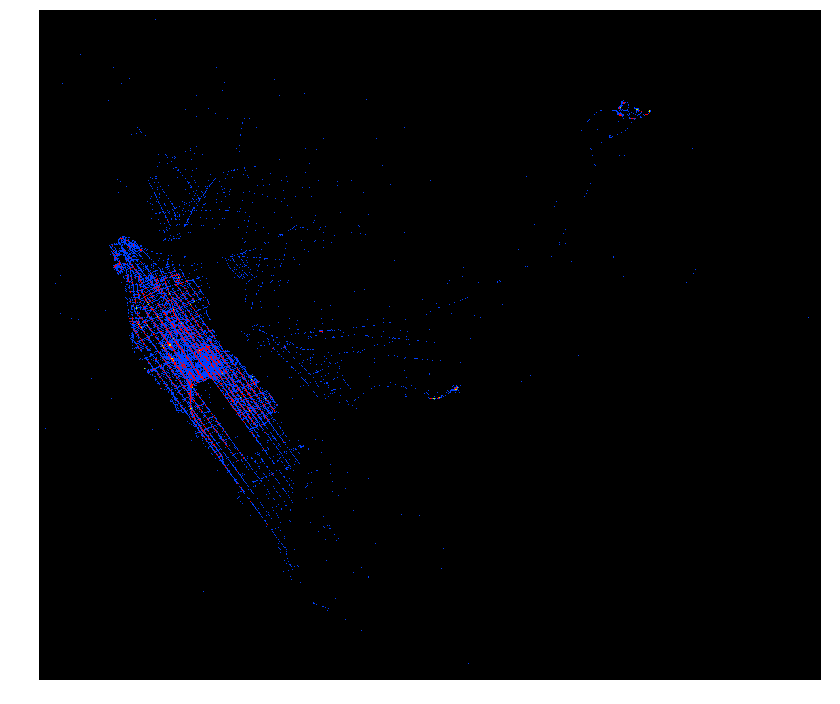

In [52]:
summary_plot.reset_index(inplace = True)
summary_plot.head(120)
lat_list = summary_plot['pick_lat_new'].unique()

for i in lat_list: #lat_list: list of unique 'pick_lat_new'
    lon_list = summary_plot.loc[summary_plot['pick_lat_new']==i]['pick_lon_new'].tolist()
    # Get the new longitude mapping with specific new latitude.
    
    unit = summary_plot.loc[summary_plot['pick_lat_new']==i]['id'].tolist()
    # Get the id list mapping with specific new latitude.
    
    for j in lon_list: # mapping id with each new longtitue in lon_list
        a = unit[lon_list.index(j)] 
        # lon_list.index(j): return the index of lon_list(j)
        
        if (a//50) >0: 
            # //: Floor Division: the result is the quotient in which the digits after decimal points are not taken into account.
            rgb[i,j, 0] = 191 #Label the count>50 with Green
            rgb[i,j, 1] = 255
            rgb[i,j, 2] = 0
        elif (a//10)>0: #Label the count>10 with Red
            rgb[i,j, 0] = 255
            rgb[i,j, 1] = 0
            rgb[i,j, 2] = 0
        else: #Label the count>10 with blue
            rgb[i,j, 0] = 0
            rgb[i,j, 1] = 64
            rgb[i,j, 2] = 255

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,20))
#plt.subplots():Create a figure and a set of subplots.
#nrows, ncols : int, optional, default: 1. Number of rows/columns of the subplot grid.
end = time.time()
print("Time taken by above cell is {}.".format((end-start)))
ax.imshow(rgb, cmap = 'hot') 
#ax.imshow():Display an image on the axes.
ax.set_axis_off() 

print('unit:',unit)


# Animate the pickups hot area: 

#### Utilized the same distance defined previously

In [53]:
start = time.time()
def haversine_(lat1, lng1, lat2, lng2):
    """function to calculate haversine distance between two co-ordinates"""
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return(h)

def manhattan_distance_pd(lat1, lng1, lat2, lng2):
    """function to calculate manhatten distance between pick_drop"""
    a = haversine_(lat1, lng1, lat1, lng2)
    b = haversine_(lat1, lng1, lat2, lng1)
    return a + b

import math
def bearing_array(lat1, lng1, lat2, lng2):
    """ function was taken from beluga's notebook as this function works on array
    while my function used to work on individual elements and was noticably slow"""
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

end = time.time()
print("Time taken by above cell is {}.".format((end-start)))

Time taken by above cell is 0.0009975433349609375.


#### Feature extratction for further pickup animation.

- Define funtions to unfold features:
- Find out features which are affecting the trip-duration between a given pickup and drop-off locations.  
- Re-define some date/time features for this part.  
- Re-define Haversine, Manhattan, Bearing distance based on pickup/dropoff lat/long for further animation.

In [54]:
start = time.time()
train_data = temp.copy()

train_data['pickup_datetime'] = pd.to_datetime(train_data.pickup_datetime)
train_data.loc[:, 'pick_month'] = train_data['pickup_datetime'].dt.month
train_data.loc[:, 'hour'] = train_data['pickup_datetime'].dt.hour
train_data.loc[:, 'week_of_year'] = train_data['pickup_datetime'].dt.weekofyear
train_data.loc[:, 'day_of_year'] = train_data['pickup_datetime'].dt.dayofyear
train_data.loc[:, 'day_of_week'] = train_data['pickup_datetime'].dt.dayofweek
train_data.loc[:,'hvsine_pick_drop'] = haversine_(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)
train_data.loc[:,'manhtn_pick_drop'] = manhattan_distance_pd(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)
train_data.loc[:,'bearing'] = bearing_array(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)

end = time.time()
print("Time taken by above cell is {}.".format(end-start))

Time taken by above cell is 253.21142721176147.


## Animation of pickups

#### Define some functions for animation:  
- Make a dynamic animation for pickup and see how with pickup hours the traffic changes.
- Make similar heatmaps of pickup locations for different pickup hours, and then make a animation stack for these images in order to check how the trip density change dynamically with the hours change.

In [55]:
start = time.time()

def color(hour):
    """function for color change in animation"""
    return(10*hour)

def Animation(hour, temp, rgb):
    """Function to generate return a picture of plotings"""
    train_data_new = temp.loc[temp['hour'] == hour]
    start = time.time()
    
    rgb = np.zeros((3000, 3500, 3), dtype=np.uint8)
    rgb[..., 0] = 0
    rgb[..., 1] = 0
    rgb[..., 2] = 0
    
    train_data_new['pick_lat_new'] = list(map(int, (train_data_new['pickup_latitude'] - (40.6000))*10000))
    train_data_new['drop_lat_new'] = list(map(int, (train_data_new['dropoff_latitude'] - (40.6000))*10000))
    train_data_new['pick_lon_new'] = list(map(int, (train_data_new['pickup_longitude'] - (-74.050))*10000))
    train_data_new['drop_lon_new'] = list(map(int,(train_data_new['dropoff_longitude'] - (-74.050))*10000))

    summary_plot = pd.DataFrame(train_data_new.groupby(['pick_lat_new', 'pick_lon_new'])['id'].count())
    summary_plot.reset_index(inplace = True)
    #summary_plot.head(120)
    
    lat_list = summary_plot['pick_lat_new'].unique()
    
    for i in lat_list:  
        lon_list = summary_plot.loc[summary_plot['pick_lat_new']==i]['pick_lon_new'].tolist()
        unit = summary_plot.loc[summary_plot['pick_lat_new']==i]['id'].tolist()
        
        for j in lon_list:
            #j = int(j)
            a = unit[lon_list.index(j)]
            
            if (a//50) >0: # Change the color with changes of hours: 
                #The colder color family: busiest; 
                #The warmer color family: less busy.
                rgb[i][j][0] = 255 - color(hour)
                rgb[i,j, 1] = 255 - color(hour)
                rgb[i,j, 2] = 0 + color(hour)
                
            elif (a//10)>0:
                rgb[i,j, 0] = 0 + color(hour)
                rgb[i,j, 1] = 255 - color(hour)
                rgb[i,j, 2] = 0 + color(hour)
                
            else:
                rgb[i,j, 0] = 255 - color(hour)
                rgb[i,j, 1] = 0 + color(hour)
                rgb[i,j, 2] = 0 + color(hour)

    end = time.time()
    print("Time taken by above cell is {} for {}.".format((end-start), hour))
    return(rgb)

end = time.time()
print("Time taken by above cell is {}.".format(end -start))

Time taken by above cell is 0.0009975433349609375.


#### Stack the images according to hours.

In [56]:
start = time.time()

images_list=[]

train_data_new['pickup_datetime'] = pd.to_datetime(train_data_new.pickup_datetime)
train_data_new.loc[:, 'hour'] = train_data_new['pickup_datetime'].dt.hour

for i in list(range(0, 24)): # Generate and stacked the images with different color over the 24 hours.
    im = Animation(i, train_data_new, rgb.copy())
    images_list.append(im)
    
end = time.time()
print("Time taken by above cell is {}.".format(end -start))

c:\python37\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

c:\python37\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

c:\python37\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

c:\python37\l

Time taken by above cell is 5.282874822616577 for 0.
Time taken by above cell is 3.428830146789551 for 1.
Time taken by above cell is 2.4943313598632812 for 2.
Time taken by above cell is 2.9690678119659424 for 3.
Time taken by above cell is 2.87729811668396 for 4.
Time taken by above cell is 3.4816572666168213 for 5.
Time taken by above cell is 3.5585176944732666 for 6.
Time taken by above cell is 3.1296329498291016 for 7.
Time taken by above cell is 3.598360776901245 for 8.
Time taken by above cell is 3.9394657611846924 for 9.
Time taken by above cell is 3.2732815742492676 for 10.
Time taken by above cell is 3.3640005588531494 for 11.
Time taken by above cell is 3.5764000415802 for 12.
Time taken by above cell is 3.057856798171997 for 13.
Time taken by above cell is 3.4916622638702393 for 14.
Time taken by above cell is 3.0658388137817383 for 15.
Time taken by above cell is 3.5654659271240234 for 16.
Time taken by above cell is 3.653233766555786 for 17.
Time taken by above cell is 3.

#### Define a function to build and save gif.
- Rule: Generate individual picture according to hours-->img_list-->pass the list into build_gif().  
-  ImageMagick® is used to create, edit, compose, or convert bitmap images.  
https://imagemagick.org/

In [57]:
start = time.time()

def build_gif(imgs = images_list, show_gif=False, save_gif=True, title=''):
    """function to create a gif of heatmaps"""
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))
    ax.set_axis_off()
    hr_range = list(range(0,24))
    
    def show_im(pairs):
        ax.clear()
        ax.set_title('Traffic- Hour ' + str(int(pairs[0])) + ':00')
        ax.imshow(pairs[1])
        ax.set_axis_off() 
        
    pairs = list(zip(hr_range, imgs)) # Match the image and hour number.
    
    # Call animation function to convert images (in images_list) to gif.
    im_ani = animation.FuncAnimation(fig, show_im, pairs,interval=500, repeat_delay=0, blit=False) # from matplotlib import animation
    
    plt.cla() #Clear the current axes.
    
    if save_gif:
        plt.rcParams["animation.convert_path"] = "C:\DataAnalytics\ImageMagick-7.0.7-Q16\convert.exe" # magick.exe
        im_ani.save('animation.gif', writer='imagemagick') #, writer='imagemagick'
        
    if show_gif:
        plt.show()
    return

end = time.time()
print("Time taken by above cell is {}".format(end-start))

Time taken by above cell is 0.0


22.7244393825531


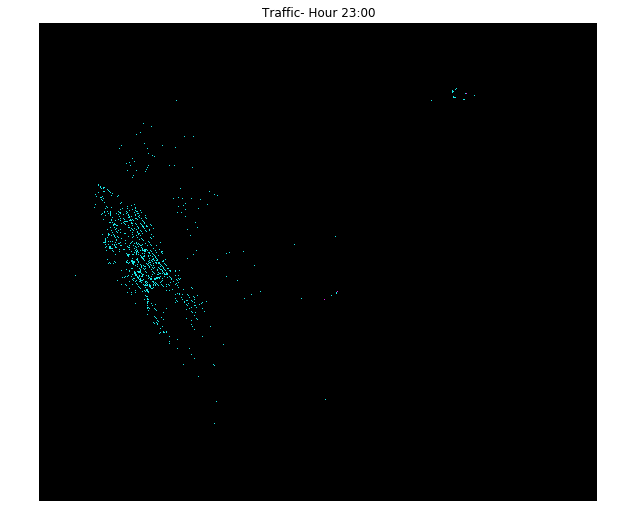

In [58]:
start = time.time()
build_gif()
end = time.time()
print(end-start)

- The gif file has been saved.


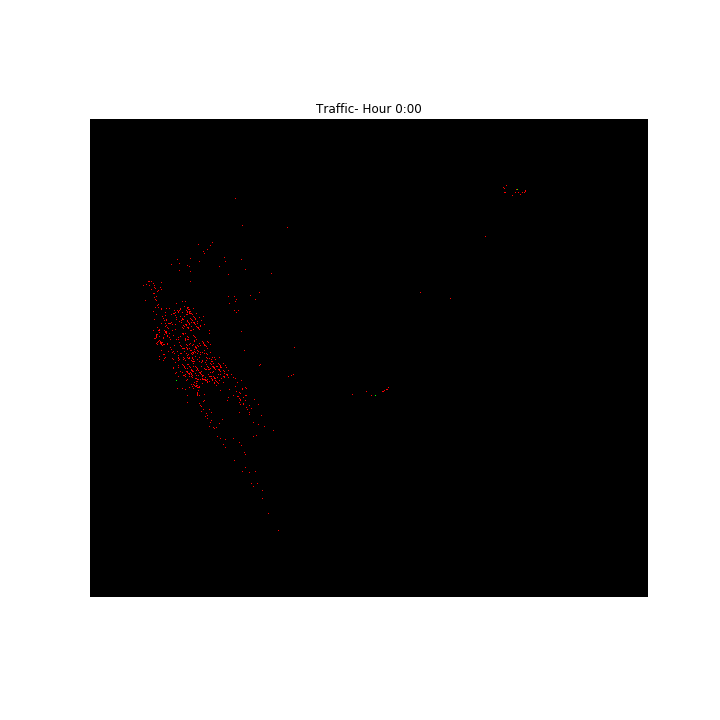

In [59]:
filename = 'animation.gif'
video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

#### Check the dynamic .gif image: 
https://github.com/ziweifan177/Data_Science_Pilot/blob/master/%5BProjects%20and%20Testing%5D%20Data%20Science%20%26%20Machine%20Learning/Analysis%20%26%20Predict%20trip%20duration%20of%20taxi%20Based%20on%20Climate%20%26%20Geospatial%C2%A0data/Result/animation.gif

### Findings:
#### 1. The least number of request comes from time 2 AM-7 AM, from 7 AM -4 PM the requests were moderate in number, and from 5 PM-1 AM in night, there is a huge amount of request of cabs in all NYC.
#### 2. The dot in the top right corner of this animation is JFK Airport: people are moving less between 2 AM to 6 AM with same rules.

## Other Exploration (Checking if any explainable pattern)

#### Relation between vendor, weekday and trip duration:  
- Concentrate on 3 features 'vendor_id','day_of_week', 'trip_duration'
- The plot is expected to explore:
    - Which weekday is the busiest day during one week?  
    - Which vendor has more trip duration? (Or is any relationship between trip duration and vendor?)  
    - ...

c:\python37\lib\site-packages\seaborn\timeseries.py:183: UserWarning:

The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.



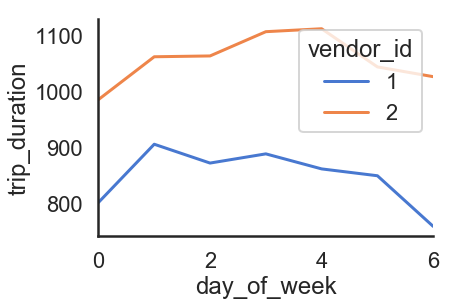

In [60]:
summary_wdays_avg_duration = pd.DataFrame(train_data.groupby(['vendor_id','day_of_week'])['trip_duration'].mean())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1

sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.tsplot(data=summary_wdays_avg_duration, time="day_of_week", unit = "unit", condition="vendor_id", value="trip_duration")
sns.despine(bottom = False)

#### Findings:
1. __Busy weekday:__
    - For vendor 1:  
        - Mon is the businest day;
    - For vendor 2:
        - Wed is the businest day;
    
2. __Trip duration VS Vendor__:  
    - Vendor 1 takes much shorter time than vendor 2 to get to the destination. WHY?....

## Further Step for this part:  
- It is interesting that vendor 2 always takes much longer time than vendor 1.   
- To figure out the underlying reason, the further work will get sementic analytics to explore the real feeling from twittee posters who have feedback about the vendor 2.

## Cluster analysis and visualization by Folium map

#### Define function to predict drop by KMeans:  
- KMean:  
    - __Parameters__: 
        - __n_clusters:__  
            - The number of clusters to form as well as the number of centroids to generate.  
        - __init:__  
            - If an ndarray is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.   
                - n_clusters: init must have exactly n_clusters rows.
                - n_features: the dimensionality of your sample. For instance, if you were to cluster points on a 2D plane, n_features would be 2.
        - __n_init:__  
            - Number of time the k-means algorithm will be run with different centroid seeds. 
- Predict the label_drop according to k_means model

In [61]:
start = time.time()

def assign_cluster(df, k):
    """function to assign clusters """
    
    df_pick = df[['pickup_longitude','pickup_latitude']]
    df_drop = df[['dropoff_longitude','dropoff_latitude']]

    #20 lat-log in init array:  for setting initial centroids via init
    init = np.array([[ -73.98737616,   40.72981533],
       [-121.93328857,   37.38933945],
       [ -73.78423222,   40.64711269],
       [ -73.9546417 ,   40.77377538],
       [ -66.84140269,   36.64537175],
       [ -73.87040541,   40.77016484],
       [ -73.97316185,   40.75814346],
       [ -73.98861094,   40.7527791 ],
       [ -72.80966949,   51.88108444],
       [ -76.99779701,   38.47370625],
       [ -73.96975298,   40.69089596],
       [ -74.00816622,   40.71414939],
       [ -66.97216034,   44.37194443],
       [ -61.33552933,   37.85105133],
       [ -73.98001393,   40.7783577 ],
       [ -72.00626526,   43.20296402],
       [ -73.07618713,   35.03469086],
       [ -73.95759366,   40.80316361],
       [ -79.20167796,   41.04752096],
       [ -74.00106031,   40.73867723]])
    
    k_means_pick = KMeans(n_clusters=k, init=init, n_init=1) #from sklearn.cluster import KMeans 
    k_means_pick.fit(df_pick) #df_pick=df[['pickup_longitude','pickup_latitude']]
    # Use the kmeans model which initialized by 'init' centroids, to fit the df_pick dataset.
    
    clust_pick = k_means_pick.labels_ 
    df['label_pick'] = clust_pick.tolist()
    #Get the pick labels by kmeans model.
    
    df['label_drop'] = k_means_pick.predict(df_drop) #df_drop = df[['dropoff_longitude','dropoff_latitude']]
    #predict the label_drop according to k_means_pick model.
    
    return df, k_means_pick

end = time.time()
print("time taken by thie script by now is {}.".format(end-start))

time taken by thie script by now is 0.0.


#### Add Centroid to dataframe:  
- By using the previous kmeans model trained by centroids array,
- To create centroids and labels columns for pick/drop lat/long 
- Merge the centroids and pick/drop labels columns to dataset predicted.

In [62]:
train_cl, k_means = assign_cluster(train_data, 20)  #K-means: n_clusters=20

#Generate Centroid of pickup/dropoff.
centroid_pickups = pd.DataFrame(k_means.cluster_centers_, columns = ['centroid_pick_long', 'centroid_pick_lat'])
centroid_dropoff = pd.DataFrame(k_means.cluster_centers_, columns = ['centroid_drop_long', 'centroid_drop_lat'])

centroid_pickups['label_pick'] = centroid_pickups.index
centroid_dropoff['label_drop'] = centroid_dropoff.index

#Add centroid to train_cl:
train_cl = pd.merge(train_cl, centroid_pickups, how='left', on=['label_pick'])
train_cl = pd.merge(train_cl, centroid_dropoff, how='left', on=['label_drop'])

train_cl.head(2)


id  vendor_id     pickup_datetime dropoff_datetime  passenger_count  \
0  id2875421          2 2016-03-14 17:24:00  3/14/2016 17:32                1   
1  id2377394          1 2016-06-12 00:43:00   6/12/2016 0:54                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.982155        40.767937         -73.964630         40.765602   
1        -73.980415        40.738564         -73.999481         40.731152   

  store_and_fwd_flag  ...  day_of_week  hvsine_pick_drop  manhtn_pick_drop  \
0                  N  ...            0          1.498521          1.735434   
1                  N  ...            6          1.805508          2.430507   

      bearing  label_pick  label_drop  centroid_pick_long  centroid_pick_lat  \
0   99.970217          14           6          -73.980067          40.778312   
1 -117.153775           0          19          -73.987495          40.729582   

   centroid_drop_long  centroid_drop_lat  
0          -73.973204          40.758161  
1          -74.001079          40.738626  

[2 rows x 28 columns]

#### Cluster related features:
- __Generate some new features for further exploration:__  
    - __hvsine_pick_cent_p/hvsine_drop_cent_d/hvsine_cent_p_cent_d:__  
        - Haversine distance of pick/drop location(lat/long) and centroid of pick/drop.  
        - Haversine distance between centroids of pick/drop.
    - __manhtn_pick_cent_p/manhtn_drop_cent_d/manhtn_cent_p_cent_d:__  
        - Manhattan distance of pick/drop location(lat/long) and centroid of pick/drop.  
        - Manhattan distance between centroids of pick/drop.
    - __bearing_pick_cent_p/bearing_drop_cent_p/bearing_cent_p_cent_d:__  
        - Bearing direction of pick/drop location(lat/long) and centroid of pick/drop.  
        - Bearing direction between centroids of pick/drop.
    - __speed_hvsn__:  
        - Average Speed based on Haversine distance.  
    - __speed_manhtn:__  
        - Average Speed based on Manhattan distance.  

In [63]:
start = time.time()

# Haversine distance:
train_cl.loc[:,'hvsine_pick_cent_p'] = haversine_(train_cl['pickup_latitude'].values, train_cl['pickup_longitude'].values, train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values)
train_cl.loc[:,'hvsine_drop_cent_d'] = haversine_(train_cl['dropoff_latitude'].values, train_cl['dropoff_longitude'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)
train_cl.loc[:,'hvsine_cent_p_cent_d'] = haversine_(train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)

# Manhattan distance:
train_cl.loc[:,'manhtn_pick_cent_p'] = manhattan_distance_pd(train_cl['pickup_latitude'].values, train_cl['pickup_longitude'].values, train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values)
train_cl.loc[:,'manhtn_drop_cent_d'] = manhattan_distance_pd(train_cl['dropoff_latitude'].values, train_cl['dropoff_longitude'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)
train_cl.loc[:,'manhtn_cent_p_cent_d'] = manhattan_distance_pd(train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)

# Bearing direction:
train_cl.loc[:,'bearing_pick_cent_p'] = bearing_array(train_cl['pickup_latitude'].values, train_cl['pickup_longitude'].values, train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values)
train_cl.loc[:,'bearing_drop_cent_p'] = bearing_array(train_cl['dropoff_latitude'].values, train_cl['dropoff_longitude'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)
train_cl.loc[:,'bearing_cent_p_cent_d'] = bearing_array(train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)

train_cl['speed_hvsn'] = train_cl.hvsine_pick_drop/train_cl.total_travel_time
train_cl['speed_manhtn'] = train_cl.manhtn_pick_drop/train_cl.total_travel_time

end = time.time()
print("Time Taken by above cell is {}.".format(end-start))

train_cl.head(3)

Time Taken by above cell is 4.63098669052124.


id  vendor_id     pickup_datetime dropoff_datetime  passenger_count  \
0  id2875421          2 2016-03-14 17:24:00  3/14/2016 17:32                1   
1  id2377394          1 2016-06-12 00:43:00   6/12/2016 0:54                1   
2  id3858529          2 2016-01-19 11:35:00  1/19/2016 12:10                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.982155        40.767937         -73.964630         40.765602   
1        -73.980415        40.738564         -73.999481         40.731152   
2        -73.979027        40.763939         -74.005333         40.710087   

  store_and_fwd_flag  ...  hvsine_drop_cent_d  hvsine_cent_p_cent_d  \
0                  N  ...            1.098219              2.313982   
1                  N  ...            0.841977              1.523606   
2                  N  ...            0.502869              5.729720   

   manhtn_pick_cent_p  manhtn_drop_cent_d  manhtn_cent_p_cent_d  \
0            1.329497            1.549504              2.818482   
1            1.595131            0.965757              2.150301   
2            1.132841            0.685781              7.863209   

   bearing_pick_cent_p  bearing_drop_cent_p  bearing_cent_p_cent_d  \
0             8.665546          -138.883901             165.535042   
1          -149.149108            -9.198433             -48.691562   
2           142.643863           -29.642746            -148.934761   

   speed_hvsn  speed_manhtn  
0    0.009087      0.010524  
1    0.005438      0.007321  
2    0.008318      0.010687  

[3 rows x 39 columns]

#### Cluster visualization using folium

- 1. Plot pickups location on NYC map using stamen toner terrain
- 2. Plot all clusters on Map of America

#### Define a function to return dataset which contains the new features of:  
- means of 'trip_duration':  
    - For checking the trip duration based on grouped 'label_pick', get the mean of 'trip_duration' via grouping by 'label_pick'
- count of 'id':  
    - For getting to know how many id correspond to the grouped 'label_pick', 'label_drop'.

In [64]:
def cluster_summary(sum_df):
    #agg_func = {'trip_duration':'mean','label_drop':'count','bearing':'mean','id':'count'} 
    #that's how to use agg function with groupby
    
    # Get the mean of 'trip_duration' via grouping by 'label_pick'- Check the trip duration based on grouped label_pick.
    summary_avg_time = pd.DataFrame(sum_df.groupby('label_pick')['trip_duration'].mean())
    summary_avg_time.reset_index(inplace = True)
    
    # Get the id count by grouping the 'label_pick', 'label_drop'- How many id(s) with grouped 'label_pick', 'label_drop'?
    # That means the 'label_pick', 'label_drop' have more popularity.
    summary_pref_cluster = pd.DataFrame(sum_df.groupby(['label_pick', 'label_drop'])['id'].count())
    summary_pref_cluster = summary_pref_cluster.reset_index()
    
    # Get the index of first id occurrence of maximum, by grouping 'label_pick'- This id should be the most popular one.
    summary_pref_cluster = summary_pref_cluster.loc[summary_pref_cluster.groupby('label_pick')['id'].idxmax()]
    summary = pd.merge(summary_avg_time, summary_pref_cluster, how = 'left', on = 'label_pick')
    
    # Rename the column.
    summary = summary.rename(columns={'trip_duration':'avg_triptime'})
    
    return summary


- Folium citing: http://folium.readthedocs.io/en/latest/quickstart.html

#### Define a function to generate map and add the pick up and drop coordinates

- As 'label_pick' and 'label_drop' refer to centroid_pickups.index and centroid_dropoff.index correspondingly, 
We defined 2 functions for:  
1. __show_fmaps()__:  
    - Adding 50 samples of the pick/drop lat/long to the folium map;  
    
2. __clusters_map()__:   
    - Clustered the full data, by counting the id with trip times>70000 within the range of centroids.   
    - Plot the folium map, by getting the pick/drop lat/long and caculating the average trip time of most visited region.  

In [66]:
import folium

def show_fmaps(train_data, path=1):
    """function to generate map and add the pick up and drop coordinates
    1. Path = 1 : Join pickup (blue) and drop(red) using a straight line
    """
    full_data = train_data
    
    summary_full_data = pd.DataFrame(full_data.groupby('label_pick')['id'].count())
    summary_full_data.reset_index(inplace = True)
    summary_full_data = summary_full_data.loc[summary_full_data['id']>70000] # Focus on the id>70000
    
    map_1 = folium.Map(location=[40.767937, -73.982155], zoom_start=10)     # manually added centre and zoom level
  
    new_df = train_data.loc[train_data['label_pick'].isin(summary_full_data.label_pick.tolist())].sample(50)
    # Get the 50 random sample items which 'label_pick' are all contained by summary_full_data.label_pick.
    
    new_df.reset_index(inplace = True, drop = True)
    
    for i in range(new_df.shape[0]): # :iterations: Get lat/long from each items in descent order.
        pick_long = new_df.loc[new_df.index == i]['pickup_longitude'].values[0] 
        pick_lat = new_df.loc[new_df.index == i]['pickup_latitude'].values[0]
        dest_long = new_df.loc[new_df.index == i]['dropoff_longitude'].values[0]
        dest_lat = new_df.loc[new_df.index == i]['dropoff_latitude'].values[0]
        
        folium.Marker([pick_lat, pick_long]).add_to(map_1) #Add this label_pick(lat-long) to map.
        folium.Marker([dest_lat, dest_long]).add_to(map_1)
    return map_1


def clusters_map(clus_data, full_data, tile = 'OpenStreetMap', sig = 0, zoom = 12, circle = 0, radius_ = 25):
    map_1 = folium.Map(location=[40.767923, -73.982168], zoom_start=zoom,tiles= tile) # 'Mapbox' 'Stamen Toner'
    
    summary_full_data = pd.DataFrame(full_data.groupby('label_pick')['id'].count())
    summary_full_data.reset_index(inplace = True)
    
    if sig == 1: # Focus on the items which id>70000
        summary_full_data = summary_full_data.loc[summary_full_data['id']>70000]
    
    sig_cluster = summary_full_data['label_pick'].tolist()
    clus_summary = cluster_summary(full_data) # Cluster the full_data.
    
    # For each label_pick, get the centroid of pick lat & long, and label_pick as the cluster number.
    for i in sig_cluster:
        pick_long = clus_data.loc[clus_data.index ==i]['centroid_pick_long'].values[0]
        pick_lat = clus_data.loc[clus_data.index ==i]['centroid_pick_lat'].values[0]
        clus_no = clus_data.loc[clus_data.index ==i]['label_pick'].values[0]
        
        # Get the 'label_drop' by specific 'label_pick'.
        most_visited_clus = clus_summary.loc[clus_summary['label_pick']==i]['label_drop'].values[0]
        
        # Get the Average trip time  by specific 'label_pick'.
        avg_triptime = clus_summary.loc[clus_summary['label_pick']==i]['avg_triptime'].values[0]
        pop = 'cluster = '+str(clus_no)+' & most visited cluster = ' +str(most_visited_clus) +' & avg triptime from this cluster =' + str(avg_triptime)
        
        if circle == 1:
            folium.CircleMarker(location=[pick_lat, pick_long], radius=radius_,
                    color='#F08080',
                    fill_color='#3186cc', popup=pop).add_to(map_1)
        folium.Marker([pick_lat, pick_long], popup=pop).add_to(map_1)
        
    return map_1

In [67]:
osm = show_fmaps(train_data, path=1)
osm

### Findings :
#### 1. Clusters with more than 70k pickups are taken for plotting thismap, and they are covering about 80% of the rides
#### 2. This maps shows that most of the rides are started from manhattan.

In [68]:
clus_map = clusters_map(centroid_pickups, train_cl, sig =0, zoom =3.2, circle =1, tile = 'Stamen Terrain')
clus_map

### Findings:
#### Plots are interactive click on balloon as check out the characteristics of each cluster:
- 1. Cluster number
- 2. Most frequently visited cluster from clicked cluster
- 3. Avg triptime of rides started from this cluster

## Predict trip duration by XGB model:   
__Motivation__:
- Previously, we predicted the trip duration by TPOT to generate a following optimum model by combining the OSRM data: 
'XGBRegressor(MinMaxScaler(input_matrix), learning_rate=0.1, max_depth=9, min_child_weight=3, n_estimators=100, nthread=1, subsample=0.15)'  
  <font color='red'>However, the model didn't perform perfectly in trip duration. Thus, let's try another similar XGBoost model-xgb by DMatrix (import xgboost as xgb) in order to check if performance and run time reduced.</font>  
  
__How__:
- The weather condition will affect the traffic sometimes.  
- In this section, another model-xgb has been involved for a new prediction.  
- And then explore if relation between traffic and some weather factors will affect as we expected to be a kind of 'evaluation' for the predicted results.  

__xgboost.train() VS. XGBRegressor & XGBClassifier__:
   - __xgboost.train():__ 
        - xgboost.train() is the low-level API to train the model via gradient boosting method.
        - will ignore parameter n_estimators (Number of trees to fit. Default=100)  
        - boosting iterations (i.e. n_estimators) is controlled by num_boost_round(default: 10)   
        
   - __xgboost.XGBRegressor & XGBClassifier__:   
        - will accept parameter n_estimators by default = 1000  
        - This means that everything that can be done with XGBRegressor and XGBClassifier is doable via underlying xgboost.train().  
        
   - The reason why XGBRegressor takes much longer time for training than XGBoost:  
       - XGBRegressor accepts the n_estimators by default = 1000, but XGBoost will not.

- Steps: 
    - Extract same features for test dataset
    - Train xgboost regressor will explore how we are doing with prediction, how much predicting power out extracted features have. 
    - If it did not get high accuracy, extra features will be extracted.
    - The whole process:   
        - <font color='red'>1.Extract same features-->2. Train xgboost regressor-->3. If not accurate-->4. Extract more features.</font>

#### Reload some data in case the previous data has been updated

In [70]:
# 1. Loading test data from competition and OSRM features for test data
test_df = pd.read_csv('data/test.csv')
test_fr = pd.read_csv('data/osrm/fastest_routes_test.csv')
test_fr_new = test_fr[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
test_df = pd.merge(test_df, test_fr_new, on = 'id', how = 'left')
test_df.head()

id  vendor_id  pickup_datetime  passenger_count  pickup_longitude  \
0  id3004672          1  6/30/2016 23:59                1        -73.988129   
1  id3505355          1  6/30/2016 23:59                1        -73.964203   
2  id1217141          1  6/30/2016 23:59                1        -73.997437   
3  id2150126          2  6/30/2016 23:59                1        -73.956070   
4  id1598245          1  6/30/2016 23:59                1        -73.970215   

   pickup_latitude  dropoff_longitude  dropoff_latitude store_and_fwd_flag  \
0        40.732029         -73.990173         40.756680                  N   
1        40.679993         -73.959808         40.655403                  N   
2        40.737583         -73.986160         40.729523                  N   
3        40.771900         -73.986427         40.730469                  N   
4        40.761475         -73.961510         40.755890                  N   

   total_distance  total_travel_time  number_of_steps  
0          3795.9              424.6                4  
1          2904.5              200.0                4  
2          1499.5              193.2                4  
3          7023.9              494.8               11  
4          1108.2              103.2                4

#### Extracting same features for Test data

In [71]:
#2. Extracting date time features
start = time.time()
test_data = test_df.copy()
test_data['pickup_datetime'] = pd.to_datetime(test_data.pickup_datetime)
test_data.loc[:, 'pick_month'] = test_data['pickup_datetime'].dt.month
test_data.loc[:, 'hour'] = test_data['pickup_datetime'].dt.hour
test_data.loc[:, 'week_of_year'] = test_data['pickup_datetime'].dt.weekofyear
test_data.loc[:, 'day_of_year'] = test_data['pickup_datetime'].dt.dayofyear
test_data.loc[:, 'day_of_week'] = test_data['pickup_datetime'].dt.dayofweek
end = time.time()
print("Time taken by above cell is {}.".format(end-start))

Time taken by above cell is 113.30172419548035.


#### As previous operation, we conducted Haversine/Manhanttan/Bearing again in case the previous one was not original.

In [72]:
#3. Extracting haversine, manhattan, and bearing distance and directional features 

test_data.loc[:,'hvsine_pick_drop'] = haversine_(test_data['pickup_latitude'].values, 
                                                 test_data['pickup_longitude'].values, 
                                                 test_data['dropoff_latitude'].values, 
                                                 test_data['dropoff_longitude'].values)

test_data.loc[:,'manhtn_pick_drop'] = manhattan_distance_pd(test_data['pickup_latitude'].values, 
                                                            test_data['pickup_longitude'].values, 
                                                            test_data['dropoff_latitude'].values, 
                                                            test_data['dropoff_longitude'].values)


test_data.loc[:,'bearing'] = bearing_array(test_data['pickup_latitude'].values, 
                                           test_data['pickup_longitude'].values, 
                                           test_data['dropoff_latitude'].values, 
                                           test_data['dropoff_longitude'].values)


#### As previous, predict on the pickup/dropoff labels by K means, and add the new 2 predicted results as new features to test data
- k_means_pick = KMeans(n_clusters=20, init=init, n_init=1)
- Based on the specific centroid location in array.

In [73]:
start = time.time()

test_data['label_pick'] = k_means.predict(test_data[['pickup_longitude','pickup_latitude']])
test_data['label_drop'] = k_means.predict(test_data[['dropoff_longitude','dropoff_latitude']])

test_cl = pd.merge(test_data, centroid_pickups, how='left', on=['label_pick'])
test_cl = pd.merge(test_cl, centroid_dropoff, how='left', on=['label_drop'])

#test_cl.head()
end = time.time()
print("Time Taken by above cell is {}.".format(end-start))

Time Taken by above cell is 1.1808416843414307.


#### As previous, caculate Haversine/Manhatan/Bearing direction based on pickup/dropoff location and centroid location, and created the corresponding features to merge with test data.

In [74]:
# 5. Extracting features: pickup/dropoff centroid of kinds of distances, and get aveage speed.

test_cl.loc[:,'hvsine_pick_cent_p'] = haversine_(test_cl['pickup_latitude'].values, 
                                                 test_cl['pickup_longitude'].values, 
                                                 test_cl['centroid_pick_lat'].values, 
                                                 test_cl['centroid_pick_long'].values)

test_cl.loc[:,'hvsine_drop_cent_d'] = haversine_(test_cl['dropoff_latitude'].values, 
                                                 test_cl['dropoff_longitude'].values, 
                                                 test_cl['centroid_drop_lat'].values, 
                                                 test_cl['centroid_drop_long'].values)

test_cl.loc[:,'hvsine_cent_p_cent_d'] = haversine_(test_cl['centroid_pick_lat'].values, 
                                                   test_cl['centroid_pick_long'].values, 
                                                   test_cl['centroid_drop_lat'].values, 
                                                   test_cl['centroid_drop_long'].values)

test_cl.loc[:,'manhtn_pick_cent_p'] = manhattan_distance_pd(test_cl['pickup_latitude'].values, 
                                                            test_cl['pickup_longitude'].values, 
                                                            test_cl['centroid_pick_lat'].values, 
                                                            test_cl['centroid_pick_long'].values)

test_cl.loc[:,'manhtn_drop_cent_d'] = manhattan_distance_pd(test_cl['dropoff_latitude'].values, 
                                                            test_cl['dropoff_longitude'].values, 
                                                            test_cl['centroid_drop_lat'].values, 
                                                            test_cl['centroid_drop_long'].values)

test_cl.loc[:,'manhtn_cent_p_cent_d'] = manhattan_distance_pd(test_cl['centroid_pick_lat'].values, 
                                                              test_cl['centroid_pick_long'].values, 
                                                              test_cl['centroid_drop_lat'].values, 
                                                              test_cl['centroid_drop_long'].values)

test_cl.loc[:,'bearing_pick_cent_p'] = bearing_array(test_cl['pickup_latitude'].values, 
                                                     test_cl['pickup_longitude'].values, 
                                                     test_cl['centroid_pick_lat'].values, 
                                                     test_cl['centroid_pick_long'].values)

test_cl.loc[:,'bearing_drop_cent_p'] = bearing_array(test_cl['dropoff_latitude'].values, 
                                                     test_cl['dropoff_longitude'].values, 
                                                     test_cl['centroid_drop_lat'].values, 
                                                     test_cl['centroid_drop_long'].values)

test_cl.loc[:,'bearing_cent_p_cent_d'] = bearing_array(test_cl['centroid_pick_lat'].values, 
                                                       test_cl['centroid_pick_long'].values, 
                                                       test_cl['centroid_drop_lat'].values, 
                                                       test_cl['centroid_drop_long'].values)

test_cl['speed_hvsn'] = test_cl.hvsine_pick_drop/test_cl.total_travel_time
test_cl['speed_manhtn'] = test_cl.manhtn_pick_drop/test_cl.total_travel_time

test_cl.head()

id  vendor_id     pickup_datetime  passenger_count  \
0  id3004672          1 2016-06-30 23:59:00                1   
1  id3505355          1 2016-06-30 23:59:00                1   
2  id1217141          1 2016-06-30 23:59:00                1   
3  id2150126          2 2016-06-30 23:59:00                1   
4  id1598245          1 2016-06-30 23:59:00                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.988129        40.732029         -73.990173         40.756680   
1        -73.964203        40.679993         -73.959808         40.655403   
2        -73.997437        40.737583         -73.986160         40.729523   
3        -73.956070        40.771900         -73.986427         40.730469   
4        -73.970215        40.761475         -73.961510         40.755890   

  store_and_fwd_flag  total_distance  ...  hvsine_drop_cent_d  \
0                  N          3795.9  ...            0.471186   
1                  N          2904.5  ...            4.038519   
2                  N          1499.5  ...            0.112632   
3                  N          7023.9  ...            0.133446   
4                  N          1108.2  ...            1.016874   

   hvsine_cent_p_cent_d  manhtn_pick_cent_p  manhtn_drop_cent_d  \
0              2.562637            0.325496            0.584733   
1              0.000000            1.655685            4.760786   
2              1.523606            0.422856            0.119046   
3              5.638342            0.326738            0.188522   
4              0.000000            0.620231            1.237572   

   manhtn_cent_p_cent_d  bearing_pick_cent_p  bearing_drop_cent_p  \
0              2.654021           168.890756           163.655712   
1              0.000000           -19.439062           -11.460131   
2              2.150145           -69.293015           -86.636014   
3              7.678473            29.868421          -137.626796   
4              0.000000          -145.652038           -75.616347   

   bearing_cent_p_cent_d  speed_hvsn  speed_manhtn  
0              -2.080700    0.006468      0.006861  
1               0.000000    0.013796      0.015524  
2             131.299574    0.006761      0.009557  
3            -150.607771    0.010649      0.014477  
4               0.000000    0.009310      0.013122  

[5 rows x 37 columns]

### Utilize XGBoost for prediction trip duration

In [75]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings

#### Conduct dimension reduction before training:  
- __For both training & testing dataset__:  
    - PCA for lat/long dimension reduction to get pick/dropoff PCA value as the new features.

In [76]:
train = train_cl
test = test_cl
start = time.time()
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

pca = PCA().fit(coords)
train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

end = time.time()
print("Time Taken by above cell is {}.".format(end - start))

Time Taken by above cell is 3.8451316356658936.


#### Other data processing:  

In [77]:
# Replace with 0 or 1:
train['store_and_fwd_flag_int'] = np.where(train['store_and_fwd_flag']=='N', 0, 1)
test['store_and_fwd_flag_int'] = np.where(test['store_and_fwd_flag']=='N', 0, 1)

#### Feature difference checking and concentration  
- We checked the difference of features in train and test datasets.  
- Removed some features which will not help a lot and concentrate on the more helpful features.

In [78]:
feature_names = list(train.columns)
print("Difference of features in train and test are {}".format(np.setdiff1d(train.columns, test.columns)))
print("")

do_not_use_for_training = ['pick_date','id', 'pickup_datetime', 'dropoff_datetime', 'trip_duration', 'store_and_fwd_flag']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]

print("We will be using following features for training {}.".format(feature_names))
print("")
print("Total number of features are {}.".format(len(feature_names)))

Difference of features in train and test are ['dropoff_datetime' 'trip_duration']

We will be using following features for training ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'total_distance', 'total_travel_time', 'number_of_steps', 'pick_month', 'hour', 'week_of_year', 'day_of_year', 'day_of_week', 'hvsine_pick_drop', 'manhtn_pick_drop', 'bearing', 'label_pick', 'label_drop', 'centroid_pick_long', 'centroid_pick_lat', 'centroid_drop_long', 'centroid_drop_lat', 'hvsine_pick_cent_p', 'hvsine_drop_cent_d', 'hvsine_cent_p_cent_d', 'manhtn_pick_cent_p', 'manhtn_drop_cent_d', 'manhtn_cent_p_cent_d', 'bearing_pick_cent_p', 'bearing_drop_cent_p', 'bearing_cent_p_cent_d', 'speed_hvsn', 'speed_manhtn', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'store_and_fwd_flag_int'].

Total number of features are 39.


#### Split the dataset and train by XGBoost    
- In this part, I will predict the trip duration by XGBoost model and following features:  

- 1. Target: Trip duration
- 2. Features:   
    - __Location data__: 
        'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'  
        'hvsine_pick_drop', 'manhtn_pick_drop', 'bearing'  
        'label_pick', 'label_drop'  
        'centroid_pick_long', 'centroid_pick_lat', 'centroid_drop_long', 'centroid_drop_lat'  
        'hvsine_pick_cent_p', 'hvsine_drop_cent_d', 'hvsine_cent_p_cent_d',   
        'manhtn_pick_cent_p', 'manhtn_drop_cent_d', 'manhtn_cent_p_cent_d',   
        'bearing_pick_cent_p', 'bearing_drop_cent_p', 'bearing_cent_p_cent_d'  
        'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1'
        
    - __Distance data__:  
        'total_distance', 'number_of_steps'
        
    - __Speed data__:  
        'speed_hvsn', 'speed_manhtn'
        
    - __Date/Time data__:  
        'total_travel_time', 'pick_month', 'hour', 'week_of_year', 'day_of_year', 'day_of_week'
        
    - __Other data__:  
        'vendor_id', 'passenger_count'

In [79]:
y = np.log(train['trip_duration'].values + 1)
start = time.time()

Xtr, Xv, ytr, yv = train_test_split(train[feature_names].values, y, test_size=0.2, random_state=1987)
#train_test_split(): Split arrays or matrices into random train and test subsets.
#<random_state>:If int, random_state is the seed used by the random number generator.

dtrain = xgb.DMatrix(Xtr, label=ytr) #DMatrix: object of XGBoost. The data is stored in a DMatrix object.
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[feature_names].values)

watchlist = [(dtrain, 'train'), (dvalid, 'valid')] # Specify validations set to watch performance

xgb_pars = {'min_child_weight': 50,
            'eta': 0.3, # Booster parameters- Learning rate: If you make 1 step at eta = 1.00, the step weight is 1.00. If you make 1 step at eta = 0.25, the step weight is 0.25.
            # to get the most of xgboost, the learning rate (eta) must be set as low as possible. 
            'colsample_bytree': 0.3, 
            'max_depth': 10, # Booster parameters
            'subsample': 0.8, 
            'lambda': 1., 
            'nthread': -1, # Number of parallel threads used to run XGBoost
            'booster' : 'gbtree', # Booster parameters
            'silent': 1,
            'eval_metric': 'rmse', 
            'objective': 'reg:linear'}

model = xgb.train(xgb_pars, dtrain, 15, watchlist, 
                  early_stopping_rounds=2, #If you have a validation set, you can use early stopping to find the optimal number of boosting rounds.
                  maximize=False, 
                  verbose_eval=1)
#xgb.train(): xgboost.train(params, dtrain, num_boost_round=10, evals=(), obj=None, 
# feval=None, maximize=False, early_stopping_rounds=None, evals_result=None, verbose_eval=True, 
# xgb_model=None, callbacks=None, learning_rates=None):
#1. xgb_pars: params;
#2. dtrain: (DMatrix) – Data to be trained.
#3. num_boost_round (int) – Number of boosting iterations.
#4. watchlist: (list of pairs (DMatrix, string)):List of items to be evaluated during training, this allows user to watch performance on the validation set.
#5. early_stopping_rounds (int) – The model will train until the validation score stops improving. Validation error needs to decrease at least every <early_stopping_rounds> round(s) to continue training. 
#6. maximize=False: maximize (bool) – Whether to maximize feval.
#7. verbose_eval=1: The evaluation metric on the validation set is printed at every given verbose_eval boosting stage.
end = time.time()

print("Time taken by above cell is {}.".format(end - start))
print('Modeling RMSLE %.5f' % model.best_score)

[0]	train-rmse:4.22652	valid-rmse:4.2284
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 2 rounds.
[1]	train-rmse:2.97724	valid-rmse:2.97881
[2]	train-rmse:2.11024	valid-rmse:2.11191
[3]	train-rmse:1.51219	valid-rmse:1.51418
[4]	train-rmse:1.10517	valid-rmse:1.10782
[5]	train-rmse:0.835272	valid-rmse:0.839071
[6]	train-rmse:0.654528	valid-rmse:0.659694
[7]	train-rmse:0.548987	valid-rmse:0.555741
[8]	train-rmse:0.475771	valid-rmse:0.484271
[9]	train-rmse:0.439611	valid-rmse:0.449465
[10]	train-rmse:0.418246	valid-rmse:0.429387
[11]	train-rmse:0.406723	valid-rmse:0.418923
[12]	train-rmse:0.401583	valid-rmse:0.414275
[13]	train-rmse:0.393501	valid-rmse:0.407096
[14]	train-rmse:0.391245	valid-rmse:0.405418
Time taken by above cell is 83.35588836669922.
Modeling RMSLE 0.40542


- __RMSLE__:  
    - If we want a rough sense of the spread of the distribution, we can instead get a rough sense of the spread of their logarithm,   
    - so that a RMSLE of 1.052 means e^1.052=2.86: that the "average" is 2.86 times as big as the true value.  
    - In this case, RMSLE=0.40945, so that average is e^0.40945=1.5060 times as big as the true value.

### Feature Extraction Round 2 combined with weather data

#### Preprocess the weather data loaded:  
- __Features__:  
    - precipitation, snow_fall, snow_depth, minimum temperature etc.

In [82]:
weather = pd.read_csv('data/weather_data_nyc_centralpark_2016.csv')
weather[['precipitation']] = weather[['precipitation']].replace(np.nan, 'T', regex=True)
weather[['snow_fall']] = weather[['snow_fall']].replace(np.nan, 'T', regex=True)
weather.rename(columns={'snow_fall': 'snow fall'}, inplace=True)
weather[['snow_depth']] = weather[['snow_depth']].replace(np.nan, 'T', regex=True)
weather.rename(columns={'snow_depth': 'snow depth'}, inplace=True)
##minimum_temperature
weather.rename(columns={'minimum_temperature': 'minimum temperature'}, inplace=True)
weather.head(10)

date  maximum_temperature  minimum temperature  average_temperature  \
0   1/1/2016                   42                   34                 38.0   
1   1/2/2016                   40                   32                 36.0   
2   1/3/2016                   45                   35                 40.0   
3   1/4/2016                   36                   14                 25.0   
4   1/5/2016                   29                   11                 20.0   
5   1/6/2016                   41                   25                 33.0   
6   1/7/2016                   46                   31                 38.5   
7   1/8/2016                   46                   31                 38.5   
8   1/9/2016                   47                   40                 43.5   
9  1/10/2016                   59                   40                 49.5   

  precipitation snow fall snow depth  
0             0         0          0  
1             0         0          0  
2             0         0          0  
3             0         0          0  
4             0         0          0  
5             0         0          0  
6             0         0          0  
7             0         0          0  
8             T         0          0  
9           1.8         0          0

#### Process some features:  

In [91]:
from ggplot import *
#import ggplot
import matplotlib.pyplot as plt

%matplotlib inline

weather.date = pd.to_datetime(weather.date)
weather['day_of_year']= weather.date.dt.dayofyear

weather['precipitation'].unique() #unique(): Returns the sorted unique elements of an array. 

weather['precipitation'] = np.where(weather['precipitation']=='T', '0.00', weather['precipitation'])
weather['precipitation'] = list(map(float, weather['precipitation'])) 
# map() function applies a given function to each item of an iterable (list, tuple etc.) and returns a list of the results.
# so if you want a new list and not just something to iterate over, you either need list(map(float, mylist)

weather['snow fall'] = np.where(weather['snow fall']=='T', '0.00', weather['snow fall'])
weather['snow fall'] = list(map(float, weather['snow fall']))

weather['snow depth'] = np.where(weather['snow depth']=='T', '0.00', weather['snow depth'])
weather['snow depth'] = list(map(float, weather['snow depth']))

weather.head(10)

date  maximum_temperature  minimum temperature  average_temperature  \
0 2016-01-01                   42                   34                 38.0   
1 2016-01-02                   40                   32                 36.0   
2 2016-01-03                   45                   35                 40.0   
3 2016-01-04                   36                   14                 25.0   
4 2016-01-05                   29                   11                 20.0   
5 2016-01-06                   41                   25                 33.0   
6 2016-01-07                   46                   31                 38.5   
7 2016-01-08                   46                   31                 38.5   
8 2016-01-09                   47                   40                 43.5   
9 2016-01-10                   59                   40                 49.5   

   precipitation  snow fall  snow depth  day_of_year  
0            0.0        0.0         0.0            1  
1            0.0        0.0         0.0            2  
2            0.0        0.0         0.0            3  
3            0.0        0.0         0.0            4  
4            0.0        0.0         0.0            5  
5            0.0        0.0         0.0            6  
6            0.0        0.0         0.0            7  
7            0.0        0.0         0.0            8  
8            0.0        0.0         0.0            9  
9            1.8        0.0         0.0           10

#### Define function to create dummy for transforming type:  
- Get the count of the most common directions

In [92]:
def freq_turn(step_dir):
    from collections import Counter
    
    step_dir_new = step_dir.split("|")
    a_list = Counter(step_dir_new).most_common() # Get the most common occurance.
    path = {}
    
    for i in range(len(a_list)):
        path.update({a_list[i]})
        
    a = 0
    b = 0
    c = 0
    
    if 'straight' in (path.keys()):
        a = path['straight']
        #print(a)
    if 'left' in (path.keys()):
        b = path['left']
        #print(b)
    if 'right' in (path.keys()):
        c = path['right']
        #print(c)
    return a,b,c


In [93]:
start = time.time()

train_fr['straight']= 0
train_fr['left'] = 0
train_fr['right'] = 0
train_fr['straight'], train_fr['left'], train_fr['right'] = zip(*train_fr['step_direction'].map(freq_turn))
#The zip() function take iterables (can be zero or more), 
# makes iterator that aggregates elements based on the iterables passed, and returns an iterator of tuples.

end = time.time()
print("Time Taken by above cell is {}.".format(end - start))

Time Taken by above cell is 25.632508516311646.


#### Merge the counting of common direction to data.

In [94]:
train_fr_new = train_fr[['id','straight','left','right']]
train = pd.merge(train, train_fr_new, on = 'id', how = 'left')
#train = pd.merge(train, weather, on= 'date', how = 'left')
print(len(train.columns))

47


- Merge weather data, date and location information.

In [95]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
train['date'] = train['pickup_datetime'].dt.date
#train.head()

train['date'] = pd.to_datetime(train['date'])
train = pd.merge(train, weather[['date','minimum temperature', 'precipitation', 'snow fall', 'snow depth']], on= 'date', how = 'left')
train.shape[0]

1048575

#### As Previous, we conducted the similar distance processing based on Haversine/Manhattan/Bearing.

In [96]:
train.loc[:,'hvsine_pick_cent_d'] = haversine_(train['pickup_latitude'].values, 
                                               train['pickup_longitude'].values, 
                                               train['centroid_drop_lat'].values, 
                                               train['centroid_drop_long'].values)
train.loc[:,'hvsine_drop_cent_p'] = haversine_(train['dropoff_latitude'].values, 
                                               train['dropoff_longitude'].values, 
                                               train['centroid_pick_lat'].values, 
                                               train['centroid_pick_long'].values)

test.loc[:,'hvsine_pick_cent_d'] = haversine_(test['pickup_latitude'].values, 
                                              test['pickup_longitude'].values, 
                                              test['centroid_drop_lat'].values, 
                                              test['centroid_drop_long'].values)
test.loc[:,'hvsine_drop_cent_p'] = haversine_(test['dropoff_latitude'].values, 
                                              test['dropoff_longitude'].values, 
                                              test['centroid_pick_lat'].values, 
                                              test['centroid_pick_long'].values)

print("shape of train_features is {}.".format(len(train.columns)))

shape of train_features is 54.


#### Plot and analyze how these features(weather, traffic) correlate.

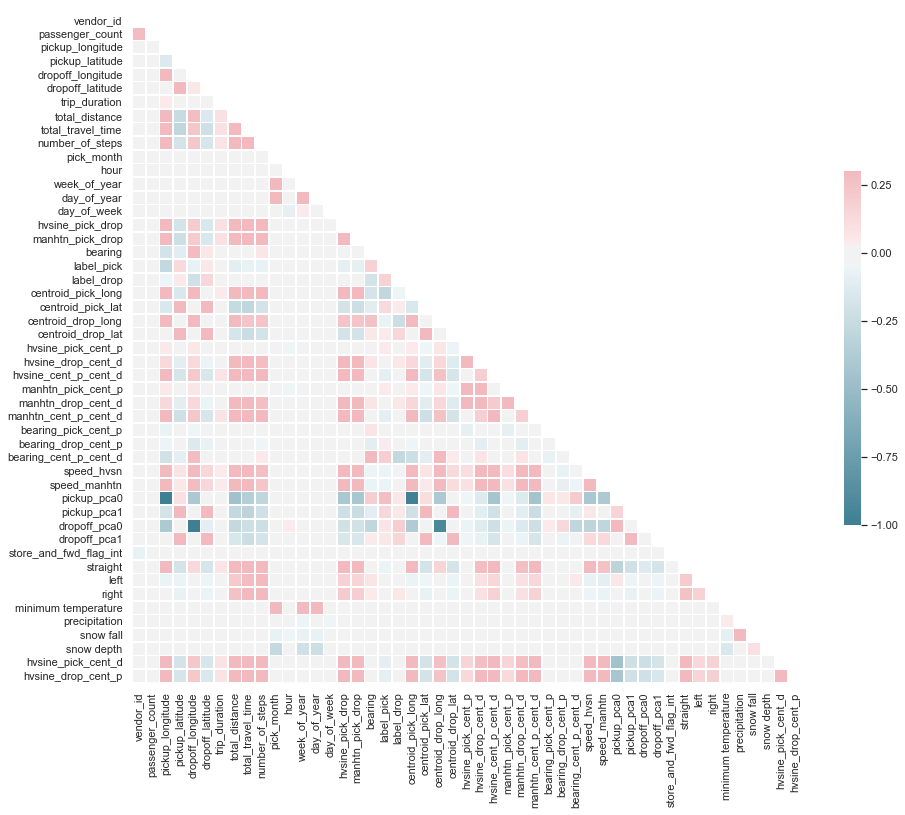

In [97]:
%matplotlib inline

sns.set(style="white")

# Generate a large random dataset
temp3 = train.copy()

# Compute the correlation matrix
corr = temp3.corr()

# for the upper triangle: Generate a mask 
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 13))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Findings:   
- According to the correlation, weather has no more correlation with traffic features, but with close correlation with date/time features.  

<font color='green'>__Negative correlation__</font>    
   - __snow depth__:  
       - pick-month, week of year, day of year;  

<font color='red'>__Positive correlation__</font>  
   - minimum temperature and pick_month, week of year, day of week

#### Other positive Correlation:
-  drop_longitude & pickup_longitude 0.3
-  dropoff_latitude & pickup_latitude, centroid_pick_lat 0.3
- etc.  
#### Other negative Correlation:
-  pickup_pca0 & pickup_longitude -0.8  
-  pickup_pca0 & dropoff_longitude -0.8
- etc.

## How Sentiment Analysis  help in evaluation the result?
__Motivation__:
- It is very curious for us to explore whether the drivers or passengers have the exactly similar emotions or feedbacks about traffic by twitter, because emotions are closely related to sentiments.  
- How Sentiment Analysis may help in exploring the other underlying factors? (Or how could we get to know if any other features affect the result?)

__How__:
- In this part, sentiment analysis based on tweepy and SnowNLP will be utilized for sentiment.  
- Twitter has the authorization by https://apps.twitter.com/app/14971757/show

In [95]:
#Import the necessary methods from tweepy library
import tweepy
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import time
from snownlp import SnowNLP

# General:
import tweepy           # To consume Twitter's API
#import pandas as pd     # To handle data
import numpy as np      # For number computing

# For plotting and visualization:
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import re

%matplotlib inline

#Variables that contain the user credentials to access Twitter API
#(Note: replace with own values from https://apps.twitter.com/)
CONSUMER_KEY='8CfHbmkzWMADgHLiZ8vpYnX5p'
CONSUMER_SECRET ='QyqVrq5z4ZBRmGSMSMf43nt4KommzH7qrGal43HW7rjSVwvsHh'

ACCESS_TOKEN='1639307029-iWG3oEUZwJoBiLwrTsHxspl7YGlGRj1PhGIYk7Y'
ACCESS_SECRET='P3ulSrZk99gcYRMvlLYve89u9JNG10KUr0fX8bZW43FSO'

- Setup twitter API by setting the key.

In [96]:
# We import our access keys:
from credentials import *    # This will allow us to use the keys as variables

# API's setup:
def twitter_setup():
    """
    Utility function to setup the Twitter's API
    with our access keys provided.
    """
    # Authentication and access using keys:
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

    # Return API with authentication:
    api = tweepy.API(auth)
    return api

#### Define functions to process twitter data.  
- searchKeyword: search twitter by specified keyword.  
- createDataFrame: Create new dataframe for storing tweets text.  
- AddDataFeature: Create new features regarding tweets attributes: RT, likes, source etc.  
- clean_tweet: remove links and special characters using regex from tweets.  
- analize_sentiment: Get the polarity by TextBlob.  
    - Polarity: It simply means emotions expressed in a sentence.
    - Subjectivity: However, it is when text is an explanatory article which must be analysed in context.  
- addSentimentFeature: Add the Polarity as new feature to the tweets datasets.  
- classifyTweets: Get the negative/positive/neutrual tweets by classification.

In [97]:
def searchKeyword(keyword):
    tweets = api.search(keyword)
    return tweets

def createDataFrame(tweets):
    data = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweets'])
    return data

def getTweetObject(tweets): ## Internal methods of a single tweet object:
    print(dir(tweets[0])) ### The interesting part from here is the quantity of metadata contained in a single tweet. If we want to obtain data such as the creation date, or the source of creation, we can access the info with this attributes.

def AddDataFeature(data, tweets):
    # We add relevant data:## we well just add some data to our dataframe. 
    # For this we will use Pythons list comprehension and a new column will be added to the dataframe 
    # by just simply adding the name of the content between square brackets and assign the content.
    data['len']  = np.array([len(tweet.text) for tweet in tweets])
    data['ID']   = np.array([tweet.id for tweet in tweets])
    data['Date'] = np.array([tweet.created_at for tweet in tweets])
    data['Source'] = np.array([tweet.source for tweet in tweets])
    data['Likes']  = np.array([tweet.favorite_count for tweet in tweets])
    data['RTs']    = np.array([tweet.retweet_count for tweet in tweets])
    return data
    
def clean_tweet(tweet):
    '''
    Utility function to clean the text in a tweet by removing 
    links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analize_sentiment(tweet):
    '''
    Utility function to classify the polarity of a tweet
    using textblob.
    '''
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1
    
def analize_sentiment_CHN(tweet):

    analysis = SnowNLP(clean_tweet(tweet))
    if analysis.sentiments.polarity > 0:
        return 1
    elif analysis.sentiments.polarity == 0:
        return 0
    else:
        return -1
    
def addSentimentFeature(data):
    # We create a column with the result of the analysis:
    data['SA'] = np.array([ analize_sentiment(tweet) for tweet in data['Tweets'] ])
    return data

def addSentimentFeature_CHN(data):
    # We create a column with the result of the analysis:
    data['SA'] = np.array([ analize_sentiment_CHN(tweet) for tweet in data['Tweets'] ])
    return data
    
def classifyTweets(data):
    # We construct lists with classified tweets:
    pos_tweets = [ tweet for index, tweet in enumerate(data['Tweets']) if data['SA'][index] > 0]
    neu_tweets = [ tweet for index, tweet in enumerate(data['Tweets']) if data['SA'][index] == 0]
    neg_tweets = [ tweet for index, tweet in enumerate(data['Tweets']) if data['SA'][index] < 0]
    
    return pos_tweets, neu_tweets, neg_tweets


#### Classify by the portion of each category.  
- We search tweets by keyword 'New York traffic' so that we could get 3 categories (positive/negative/neutrual) of tweets regarding New York Traffic by sorting in the time order. 
- By caculating the portion of each category, we approximately understand the real time emotion about the 'New York traffic' now.

In [98]:
# We create an extractor object:
api = twitter_setup()

keyword="New York traffic"
tweets=searchKeyword(keyword)
dftweets=createDataFrame(tweets)

print("Number of {} tweets extracted: {}.\n".format(keyword, len(tweets)))

# We display the first 10 elements of the dataframe:
display(dftweets.head(10))

dftweets=AddDataFeature(dftweets, tweets)

print("After adding features:\n")
display(dftweets.head(10))

dftweets=addSentimentFeature(dftweets)
print("After adding Sentiment Features:\n")
display(dftweets.head(10))

pos_tweets, neu_tweets, neg_tweets=classifyTweets(dftweets)

print("Percentage of {} positive tweets: {}%".format(keyword, len(pos_tweets)*100/len(dftweets['Tweets'])))
print("Percentage of {} neutral tweets: {}%".format(keyword, len(neu_tweets)*100/len(dftweets['Tweets'])))
print("Percentage de {} negative tweets: {}%".format(keyword, len(neg_tweets)*100/len(dftweets['Tweets'])))

Number of New York traffic tweets extracted: 15.



<div>
<style>
    .dataframe thead tr:only-child th {
        text-align: right;
    }

    .dataframe thead th {
        text-align: left;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Tweets</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>RT @schlthss: Two stats in America that have n...</td>
    </tr>
    <tr>
      <th>1</th>
      <td>RT @gatewaypundit: 5.) Exhibit 5 Western Journ...</td>
    </tr>
    <tr>
      <th>2</th>
      <td>RT @gatewaypundit: 5.) Exhibit 5 Western Journ...</td>
    </tr>
    <tr>
      <th>3</th>
      <td>RT @gatewaypundit: 5.) Exhibit 5 Western Journ...</td>
    </tr>
    <tr>
      <th>4</th>
      <td>RT @gatewaypundit: 5.) Exhibit 5 Western Journ...</td>
    </tr>
    <tr>
      <th>5</th>
      <td>RT @gatewaypundit: 5.) Exhibit 5 Western Journ...</td>
    </tr>
    <tr>
      <th>6</th>
      <td>@UnstableJessica “20 minutes away...great...fu...</td>
    </tr>
    <tr>
      <th>7</th>
      <td>RT @sarahkendzior: Dennis Shields, the residen...</td>
    </tr>
    <tr>
      <th>8</th>
      <td>RT @gatewaypundit: 5.) Exhibit 5 Western Journ...</td>
    </tr>
    <tr>
      <th>9</th>
      <td>RT @gatewaypundit: 5.) Exhibit 5 Western Journ...</td>
    </tr>
  </tbody>
</table>
</div>

After adding features:



<div>
<style>
    .dataframe thead tr:only-child th {
        text-align: right;
    }

    .dataframe thead th {
        text-align: left;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Tweets</th>
      <th>len</th>
      <th>ID</th>
      <th>Date</th>
      <th>Source</th>
      <th>Likes</th>
      <th>RTs</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>RT @schlthss: Two stats in America that have n...</td>
      <td>148</td>
      <td>984112078347743237</td>
      <td>2018-04-11 16:52:58</td>
      <td>Twitter for iPhone</td>
      <td>0</td>
      <td>19</td>
    </tr>
    <tr>
      <th>1</th>
      <td>RT @gatewaypundit: 5.) Exhibit 5 Western Journ...</td>
      <td>140</td>
      <td>984110674744827905</td>
      <td>2018-04-11 16:47:23</td>
      <td>Twitter Web Client</td>
      <td>0</td>
      <td>55</td>
    </tr>
    <tr>
      <th>2</th>
      <td>RT @gatewaypundit: 5.) Exhibit 5 Western Journ...</td>
      <td>140</td>
      <td>984110477604212736</td>
      <td>2018-04-11 16:46:36</td>
      <td>Twitter Web Client</td>
      <td>0</td>
      <td>55</td>
    </tr>
    <tr>
      <th>3</th>
      <td>RT @gatewaypundit: 5.) Exhibit 5 Western Journ...</td>
      <td>140</td>
      <td>984107888162598912</td>
      <td>2018-04-11 16:36:19</td>
      <td>Twitter Web Client</td>
      <td>0</td>
      <td>55</td>
    </tr>
    <tr>
      <th>4</th>
      <td>RT @gatewaypundit: 5.) Exhibit 5 Western Journ...</td>
      <td>140</td>
      <td>984107544594534400</td>
      <td>2018-04-11 16:34:57</td>
      <td>Twitter Web Client</td>
      <td>0</td>
      <td>55</td>
    </tr>
    <tr>
      <th>5</th>
      <td>RT @gatewaypundit: 5.) Exhibit 5 Western Journ...</td>
      <td>140</td>
      <td>984107064514498560</td>
      <td>2018-04-11 16:33:02</td>
      <td>Twitter for iPhone</td>
      <td>0</td>
      <td>55</td>
    </tr>
    <tr>
      <th>6</th>
      <td>@UnstableJessica “20 minutes away...great...fu...</td>
      <td>89</td>
      <td>984106950655819776</td>
      <td>2018-04-11 16:32:35</td>
      <td>Twitter for iPhone</td>
      <td>0</td>
      <td>0</td>
    </tr>
    <tr>
      <th>7</th>
      <td>RT @sarahkendzior: Dennis Shields, the residen...</td>
      <td>140</td>
      <td>984106473277009923</td>
      <td>2018-04-11 16:30:41</td>
      <td>Twitter for Android</td>
      <td>0</td>
      <td>288</td>
    </tr>
    <tr>
      <th>8</th>
      <td>RT @gatewaypundit: 5.) Exhibit 5 Western Journ...</td>
      <td>140</td>
      <td>984106009114365955</td>
      <td>2018-04-11 16:28:51</td>
      <td>Twitter Lite</td>
      <td>0</td>
      <td>55</td>
    </tr>
    <tr>
      <th>9</th>
      <td>RT @gatewaypundit: 5.) Exhibit 5 Western Journ...</td>
      <td>140</td>
      <td>984105727529807872</td>
      <td>2018-04-11 16:27:43</td>
      <td>Twitter for iPhone</td>
      <td>0</td>
      <td>55</td>
    </tr>
  </tbody>
</table>
</div>

After adding Sentiment Features:



<div>
<style>
    .dataframe thead tr:only-child th {
        text-align: right;
    }

    .dataframe thead th {
        text-align: left;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Tweets</th>
      <th>len</th>
      <th>ID</th>
      <th>Date</th>
      <th>Source</th>
      <th>Likes</th>
      <th>RTs</th>
      <th>SA</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>RT @schlthss: Two stats in America that have n...</td>
      <td>148</td>
      <td>984112078347743237</td>
      <td>2018-04-11 16:52:58</td>
      <td>Twitter for iPhone</td>
      <td>0</td>
      <td>19</td>
      <td>1</td>
    </tr>
    <tr>
      <th>1</th>
      <td>RT @gatewaypundit: 5.) Exhibit 5 Western Journ...</td>
      <td>140</td>
      <td>984110674744827905</td>
      <td>2018-04-11 16:47:23</td>
      <td>Twitter Web Client</td>
      <td>0</td>
      <td>55</td>
      <td>1</td>
    </tr>
    <tr>
      <th>2</th>
      <td>RT @gatewaypundit: 5.) Exhibit 5 Western Journ...</td>
      <td>140</td>
      <td>984110477604212736</td>
      <td>2018-04-11 16:46:36</td>
      <td>Twitter Web Client</td>
      <td>0</td>
      <td>55</td>
      <td>1</td>
    </tr>
    <tr>
      <th>3</th>
      <td>RT @gatewaypundit: 5.) Exhibit 5 Western Journ...</td>
      <td>140</td>
      <td>984107888162598912</td>
      <td>2018-04-11 16:36:19</td>
      <td>Twitter Web Client</td>
      <td>0</td>
      <td>55</td>
      <td>1</td>
    </tr>
    <tr>
      <th>4</th>
      <td>RT @gatewaypundit: 5.) Exhibit 5 Western Journ...</td>
      <td>140</td>
      <td>984107544594534400</td>
      <td>2018-04-11 16:34:57</td>
      <td>Twitter Web Client</td>
      <td>0</td>
      <td>55</td>
      <td>1</td>
    </tr>
    <tr>
      <th>5</th>
      <td>RT @gatewaypundit: 5.) Exhibit 5 Western Journ...</td>
      <td>140</td>
      <td>984107064514498560</td>
      <td>2018-04-11 16:33:02</td>
      <td>Twitter for iPhone</td>
      <td>0</td>
      <td>55</td>
      <td>1</td>
    </tr>
    <tr>
      <th>6</th>
      <td>@UnstableJessica “20 minutes away...great...fu...</td>
      <td>89</td>
      <td>984106950655819776</td>
      <td>2018-04-11 16:32:35</td>
      <td>Twitter for iPhone</td>
      <td>0</td>
      <td>0</td>
      <td>1</td>
    </tr>
    <tr>
      <th>7</th>
      <td>RT @sarahkendzior: Dennis Shields, the residen...</td>
      <td>140</td>
      <td>984106473277009923</td>
      <td>2018-04-11 16:30:41</td>
      <td>Twitter for Android</td>
      <td>0</td>
      <td>288</td>
      <td>0</td>
    </tr>
    <tr>
      <th>8</th>
      <td>RT @gatewaypundit: 5.) Exhibit 5 Western Journ...</td>
      <td>140</td>
      <td>984106009114365955</td>
      <td>2018-04-11 16:28:51</td>
      <td>Twitter Lite</td>
      <td>0</td>
      <td>55</td>
      <td>1</td>
    </tr>
    <tr>
      <th>9</th>
      <td>RT @gatewaypundit: 5.) Exhibit 5 Western Journ...</td>
      <td>140</td>
      <td>984105727529807872</td>
      <td>2018-04-11 16:27:43</td>
      <td>Twitter for iPhone</td>
      <td>0</td>
      <td>55</td>
      <td>1</td>
    </tr>
  </tbody>
</table>
</div>

Percentage of New York traffic positive tweets: 86.66666666666667%
Percentage of New York traffic neutral tweets: 13.333333333333334%
Percentage de New York traffic negative tweets: 0.0%


- From the portion, basically we could concluded the current weather doesn't affect the traffic for now based on real time tweets.
    - __Positive__: 86.6%  
    - __Neutral__: 13.3% and no negative tweets. 

#### For exploring if the tweet publishers have the similar polarity to the current weather, let's search by 'New York weather'. 

In [99]:
# We create an extractor object:

keyword="New York weather"
tweets=searchKeyword(keyword)
dftweets=createDataFrame(tweets)

print("Number of {} tweets extracted: {}.\n".format(keyword, len(tweets)))

# We display the first 10 elements of the dataframe:
display(dftweets.head(10))

dftweets=AddDataFeature(dftweets, tweets)

print("After adding features:\n")
display(dftweets.head(10))

dftweets=addSentimentFeature(dftweets)
print("After adding Sentiment Features:\n")
display(dftweets.head(10))

pos_tweets, neu_tweets, neg_tweets=classifyTweets(dftweets)

print("Percentage of {} positive tweets: {}%".format(keyword, len(pos_tweets)*100/len(dftweets['Tweets'])))
print("Percentage of {} neutral tweets: {}%".format(keyword, len(neu_tweets)*100/len(dftweets['Tweets'])))
print("Percentage de {} negative tweets: {}%".format(keyword, len(neg_tweets)*100/len(dftweets['Tweets'])))

Number of New York weather tweets extracted: 15.



<div>
<style>
    .dataframe thead tr:only-child th {
        text-align: right;
    }

    .dataframe thead th {
        text-align: left;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Tweets</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>RT @EnjoyNature: Cherry Blossom and Spring Mor...</td>
    </tr>
    <tr>
      <th>1</th>
      <td>New York weather as of 05:01 PM: 47.59 F</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Sexy, seductive, sophisticated... all aptly de...</td>
    </tr>
    <tr>
      <th>3</th>
      <td>current weather in New York: broken clouds, 47...</td>
    </tr>
    <tr>
      <th>4</th>
      <td>@LanceBass Thanks for the reminder, Lance. It'...</td>
    </tr>
    <tr>
      <th>5</th>
      <td>The knowledge is in your joints. By @Ali_Lev #...</td>
    </tr>
    <tr>
      <th>6</th>
      <td>Just waiting for the weather to be valid in Ne...</td>
    </tr>
    <tr>
      <th>7</th>
      <td>RT @accuweather: AccuFan Weather Photo of the ...</td>
    </tr>
    <tr>
      <th>8</th>
      <td>@KAliceCompeau It's only 44° in New York, but ...</td>
    </tr>
    <tr>
      <th>9</th>
      <td>New York weather as of 04:31 PM: 47.23 F</td>
    </tr>
  </tbody>
</table>
</div>

After adding features:



<div>
<style>
    .dataframe thead tr:only-child th {
        text-align: right;
    }

    .dataframe thead th {
        text-align: left;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Tweets</th>
      <th>len</th>
      <th>ID</th>
      <th>Date</th>
      <th>Source</th>
      <th>Likes</th>
      <th>RTs</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>RT @EnjoyNature: Cherry Blossom and Spring Mor...</td>
      <td>140</td>
      <td>984114737939173376</td>
      <td>2018-04-11 17:03:32</td>
      <td>Twitter Web Client</td>
      <td>0</td>
      <td>121</td>
    </tr>
    <tr>
      <th>1</th>
      <td>New York weather as of 05:01 PM: 47.59 F</td>
      <td>40</td>
      <td>984114206839595009</td>
      <td>2018-04-11 17:01:25</td>
      <td>data_project_twitter</td>
      <td>0</td>
      <td>0</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Sexy, seductive, sophisticated... all aptly de...</td>
      <td>143</td>
      <td>984114155941658624</td>
      <td>2018-04-11 17:01:13</td>
      <td>Likeable Business</td>
      <td>0</td>
      <td>0</td>
    </tr>
    <tr>
      <th>3</th>
      <td>current weather in New York: broken clouds, 47...</td>
      <td>89</td>
      <td>984113025505308673</td>
      <td>2018-04-11 16:56:43</td>
      <td>Cities</td>
      <td>0</td>
      <td>0</td>
    </tr>
    <tr>
      <th>4</th>
      <td>@LanceBass Thanks for the reminder, Lance. It'...</td>
      <td>140</td>
      <td>984111000168357888</td>
      <td>2018-04-11 16:48:40</td>
      <td>TweetDeck</td>
      <td>0</td>
      <td>0</td>
    </tr>
    <tr>
      <th>5</th>
      <td>The knowledge is in your joints. By @Ali_Lev #...</td>
      <td>77</td>
      <td>984110106672541696</td>
      <td>2018-04-11 16:45:07</td>
      <td>Sprout Social</td>
      <td>1</td>
      <td>0</td>
    </tr>
    <tr>
      <th>6</th>
      <td>Just waiting for the weather to be valid in Ne...</td>
      <td>74</td>
      <td>984108292623470594</td>
      <td>2018-04-11 16:37:55</td>
      <td>Twitter for iPhone</td>
      <td>0</td>
      <td>0</td>
    </tr>
    <tr>
      <th>7</th>
      <td>RT @accuweather: AccuFan Weather Photo of the ...</td>
      <td>140</td>
      <td>984107948497604609</td>
      <td>2018-04-11 16:36:33</td>
      <td>Twitter Web Client</td>
      <td>0</td>
      <td>3</td>
    </tr>
    <tr>
      <th>8</th>
      <td>@KAliceCompeau It's only 44° in New York, but ...</td>
      <td>139</td>
      <td>984107149533106176</td>
      <td>2018-04-11 16:33:22</td>
      <td>Twitter for Android</td>
      <td>1</td>
      <td>0</td>
    </tr>
    <tr>
      <th>9</th>
      <td>New York weather as of 04:31 PM: 47.23 F</td>
      <td>40</td>
      <td>984106561051258880</td>
      <td>2018-04-11 16:31:02</td>
      <td>data_project_twitter</td>
      <td>0</td>
      <td>0</td>
    </tr>
  </tbody>
</table>
</div>

After adding Sentiment Features:



<div>
<style>
    .dataframe thead tr:only-child th {
        text-align: right;
    }

    .dataframe thead th {
        text-align: left;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Tweets</th>
      <th>len</th>
      <th>ID</th>
      <th>Date</th>
      <th>Source</th>
      <th>Likes</th>
      <th>RTs</th>
      <th>SA</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>RT @EnjoyNature: Cherry Blossom and Spring Mor...</td>
      <td>140</td>
      <td>984114737939173376</td>
      <td>2018-04-11 17:03:32</td>
      <td>Twitter Web Client</td>
      <td>0</td>
      <td>121</td>
      <td>1</td>
    </tr>
    <tr>
      <th>1</th>
      <td>New York weather as of 05:01 PM: 47.59 F</td>
      <td>40</td>
      <td>984114206839595009</td>
      <td>2018-04-11 17:01:25</td>
      <td>data_project_twitter</td>
      <td>0</td>
      <td>0</td>
      <td>1</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Sexy, seductive, sophisticated... all aptly de...</td>
      <td>143</td>
      <td>984114155941658624</td>
      <td>2018-04-11 17:01:13</td>
      <td>Likeable Business</td>
      <td>0</td>
      <td>0</td>
      <td>1</td>
    </tr>
    <tr>
      <th>3</th>
      <td>current weather in New York: broken clouds, 47...</td>
      <td>89</td>
      <td>984113025505308673</td>
      <td>2018-04-11 16:56:43</td>
      <td>Cities</td>
      <td>0</td>
      <td>0</td>
      <td>-1</td>
    </tr>
    <tr>
      <th>4</th>
      <td>@LanceBass Thanks for the reminder, Lance. It'...</td>
      <td>140</td>
      <td>984111000168357888</td>
      <td>2018-04-11 16:48:40</td>
      <td>TweetDeck</td>
      <td>0</td>
      <td>0</td>
      <td>1</td>
    </tr>
    <tr>
      <th>5</th>
      <td>The knowledge is in your joints. By @Ali_Lev #...</td>
      <td>77</td>
      <td>984110106672541696</td>
      <td>2018-04-11 16:45:07</td>
      <td>Sprout Social</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
    </tr>
    <tr>
      <th>6</th>
      <td>Just waiting for the weather to be valid in Ne...</td>
      <td>74</td>
      <td>984108292623470594</td>
      <td>2018-04-11 16:37:55</td>
      <td>Twitter for iPhone</td>
      <td>0</td>
      <td>0</td>
      <td>1</td>
    </tr>
    <tr>
      <th>7</th>
      <td>RT @accuweather: AccuFan Weather Photo of the ...</td>
      <td>140</td>
      <td>984107948497604609</td>
      <td>2018-04-11 16:36:33</td>
      <td>Twitter Web Client</td>
      <td>0</td>
      <td>3</td>
      <td>1</td>
    </tr>
    <tr>
      <th>8</th>
      <td>@KAliceCompeau It's only 44° in New York, but ...</td>
      <td>139</td>
      <td>984107149533106176</td>
      <td>2018-04-11 16:33:22</td>
      <td>Twitter for Android</td>
      <td>1</td>
      <td>0</td>
      <td>-1</td>
    </tr>
    <tr>
      <th>9</th>
      <td>New York weather as of 04:31 PM: 47.23 F</td>
      <td>40</td>
      <td>984106561051258880</td>
      <td>2018-04-11 16:31:02</td>
      <td>data_project_twitter</td>
      <td>0</td>
      <td>0</td>
      <td>1</td>
    </tr>
  </tbody>
</table>
</div>

Percentage of New York weather positive tweets: 60.0%
Percentage of New York weather neutral tweets: 13.333333333333334%
Percentage de New York weather negative tweets: 26.666666666666668%


#### Findings:  
<img src='Image/Comparison2.png' style="width: 400px;">  
- The majority of publisher think current New York weather is good, by portion of <font color='red'> 60% </font>. This aligned with the previous traffic results.  
- And more <font color='green'>(26.7%)</font> publishers think current weather is bad,  26.7% more than traffic results.  

__By comparing the 2 sentiment analysis:__  
   - Even though negativeness increase by 26.7% in weather than traffic, the 'negative' weather didn't affect a lot to traffic.  
   - This result aligned well with the correlation chart above:  
       - The weather correlated to the day/week/month more than traffic.  
       - Traffic features correlated to the internal traffic features.   
   - Let us imagine: What if the more positive tweets in weather than in traffic?  
       - That means there may be some other factors (like accident etc.) affect the traffic rather than weather. 

## Reference:
- Law-of-haversines:  https://en.wikipedia.org/wiki/Haversine_formula  
- Encoding cyclical continuous features - 24-hour time: https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/  
- Comparison of the K-Means and MiniBatchKMeans clustering algorithms: https://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html  
- Clustering: https://scikit-learn.org/stable/modules/clustering.html#mini-batch-kmeans  
- TPOT github: https://github.com/EpistasisLab/tpot    
- Cross-validation: evaluating estimator performance https://scikit-learn.org/stable/modules/cross_validation.html  
- TPOT Automated Machine Learning in Python https://towardsdatascience.com/tpot-automated-machine-learning-in-python-4c063b3e5de9  
- XGBoost Python Package Introduction: https://xgboost.readthedocs.io/en/latest/python/python_intro.html  